In [42]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os.path
import sys
from os import path
sns.set_theme(style="whitegrid")

In [57]:
def get_edge_features(dataset):
    nodes_info = pd.read_csv(f"{dataset}/nodeQualityFeatures.txt", sep="\t")
    nodes_info['out_homophily'] = [row['redNeighborsOutRatio'] if row['group'] == 1 else 1 - row['redNeighborsOutRatio']
                               for i, row in nodes_info.iterrows()]
    edges_scores = pd.read_csv(f"{dataset}/deletion_scores.txt")
    df = edges_scores.join(nodes_info.set_index("nodeId"), on="Source", rsuffix="source")
    df = df.join(nodes_info.set_index("nodeId"), on="Target", lsuffix="_source", rsuffix="_target")
    df = df.sort_values(axis=0, by="Score", ascending=False)
    df["red_pagerank_dif"] = df["redPagerank_target"] - df["redPagerank_source"]
    # 2 * a + 1 * b.
    # 0: blue to blue, 1: blue to red, 2: red to blue, 3 red to red
    df["edge_group"] = (2 * df["group_source"]) + df["group_target"]
    
    # To get distances ##################
    edges = [(i, j) for i,j in zip(df.Source, df.Target)]
    f = open(f"{dataset}/out_graph.txt")
    lines = f.readlines()
    f.close()
    G = nx.parse_edgelist(lines[1:], nodetype=int, create_using=nx.DiGraph)
    dist = list()
    for e in edges:
        try:
            length = len(nx.shortest_path(G, source=e[1], target=e[0])) - 1
            dist.append(length)
        except nx.NetworkXNoPath:
            dist.append(float("Inf"))
    df["Distance"] = dist
    #####################################
    
    return df
 

In [58]:
books = get_edge_features("books")
blogs = get_edge_features("blogs")
dblp = get_edge_features("dblp_course")
twitter = get_edge_features("twitter")

In [152]:
books_t = books.copy()
blogs_t = blogs.copy()
dblp_t = dblp.copy()
twitter_t = twitter.copy()
books_t["dataset"] = "Books"
blogs_t["dataset"] = "Blogs"
dblp_t["dataset"] = "DBPL"
twitter_t["dataset"] = "Twitter"
frames = [blogs_t[["Score", "edge_group", "dataset"]],
          dblp_t[["Score", "edge_group", "dataset"]], twitter_t[["Score", "edge_group", "dataset"]]]
df = pd.concat(frames)

In [137]:
books_t.head()

Source  Target     Score  pagerank_source  redPagerank_source  \
76      61      82  0.004884         0.008490            0.352909   
79      61      21  0.004222         0.008490            0.352909   
73      78      77  0.001142         0.006369            0.864965   
72      78      22  0.000723         0.006369            0.864965   
77      61      69  0.000493         0.008490            0.352909   

    group_source  inDegree_source  outDegree_source  \
76             0                6                 6   
79             0                6                 6   
73             1                4                 4   
72             1                4                 4   
77             0                6                 6   

    redNeighborsInRatio_source  redNeighborsOutRatio_source  ...  \
76                    0.333333                     0.333333  ...   
79                    0.333333                     0.333333  ...   
73                    1.000000                     1.000000  ...   
72                    1.000000                     1.000000  ...   
77                    0.333333                     0.333333  ...   

    group_target  inDegree_target  outDegree_target  \
76             1               20                20   
79             1                9                 9   
73             1               19                19   
72             1               17                17   
77             0               10                10   

    redNeighborsInRatio_target  redNeighborsOutRatio_target  \
76                    0.950000                     0.950000   
79                    0.777778                     0.777778   
73                    1.000000                     1.000000   
72                    0.882353                     0.882353   
77                    0.500000                     0.500000   

    out_homophily_target  red_pagerank_dif  edge_group  Distance  dataset  
76              0.950000          0.562983           1         1    Books  
79              0.777778          0.499728           1         1    Books  
73              1.000000          0.068929           3         1    Books  
72              0.882353          0.034832           3         1    Books  
77              0.500000          0.113331           0         1    Books  

[5 rows x 23 columns]

<IPython.core.display.Javascript object>


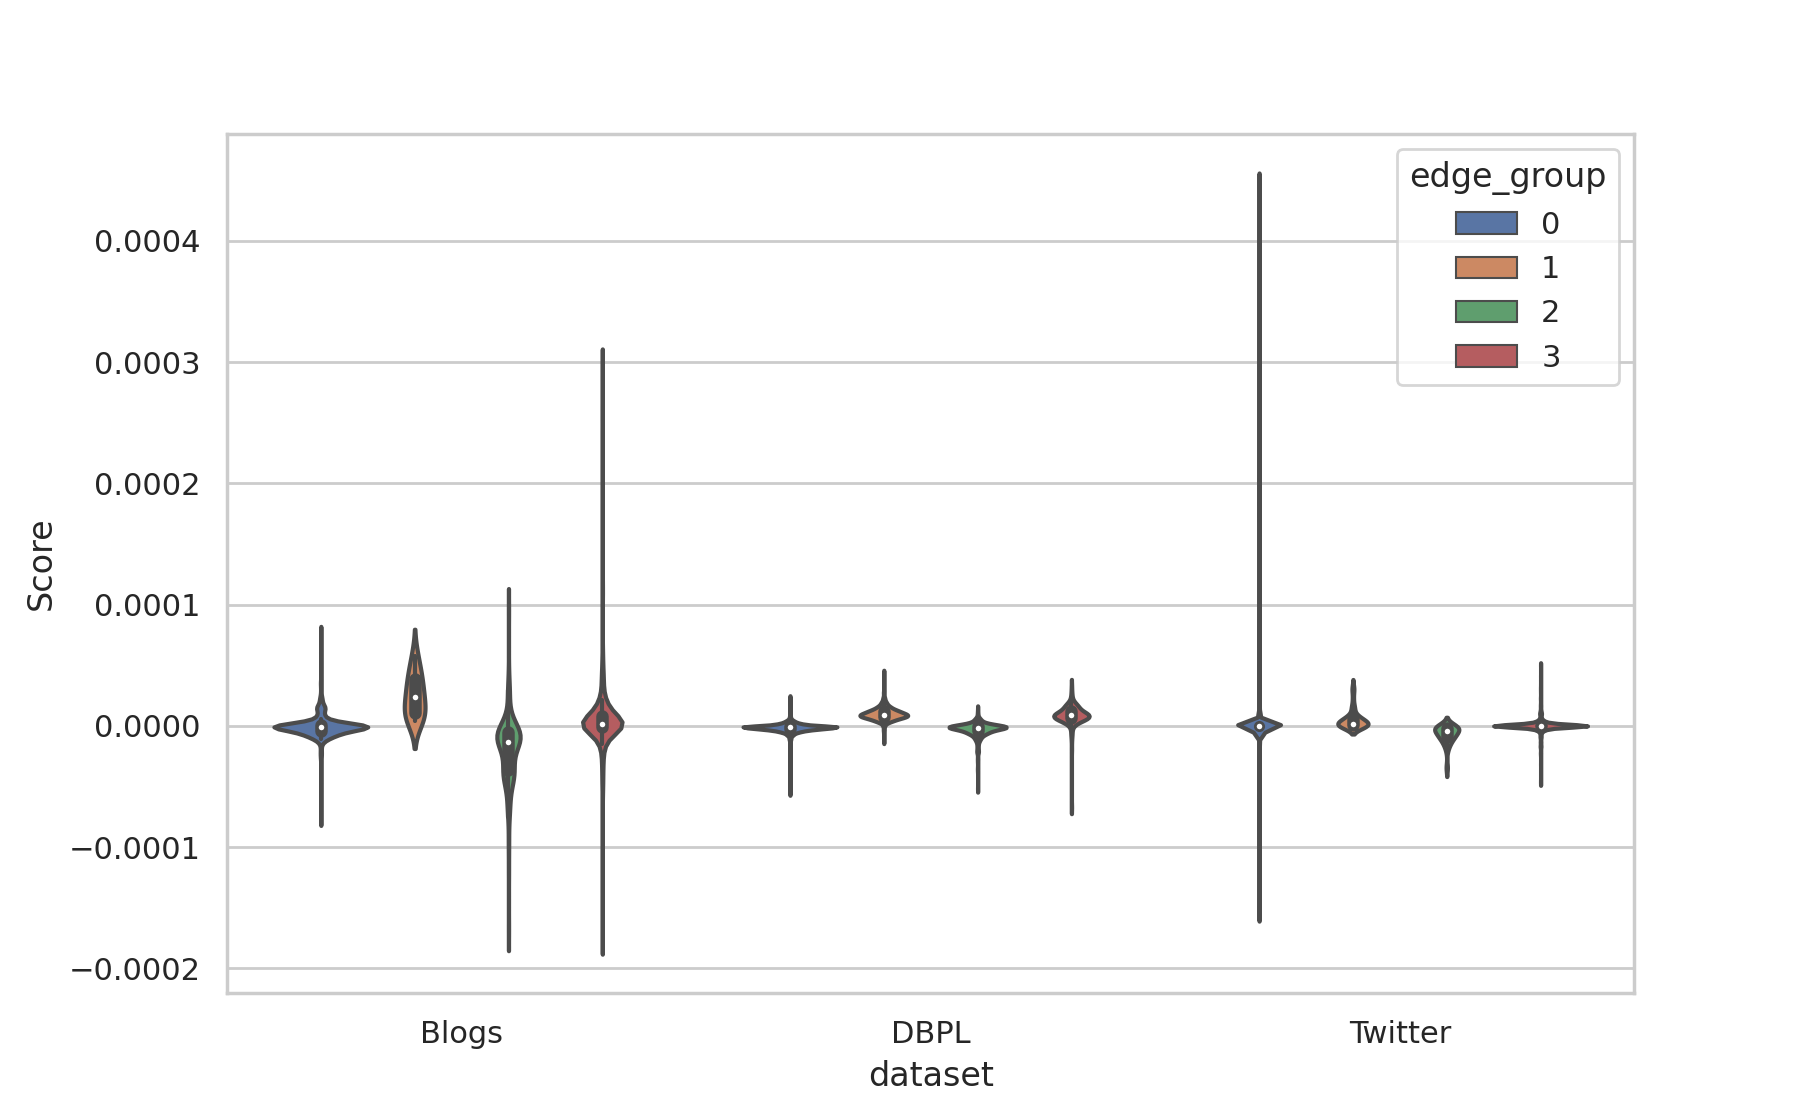

In [154]:
# sns.barplot(x="dataset", y="Score", hue="edge_group", data=df)
# sns.boxplot(x="dataset", y="Score", hue="edge_group", data=df)
sns.violinplot(x="dataset", y="Score", hue="edge_group", data=df)

<IPython.core.display.Javascript object>


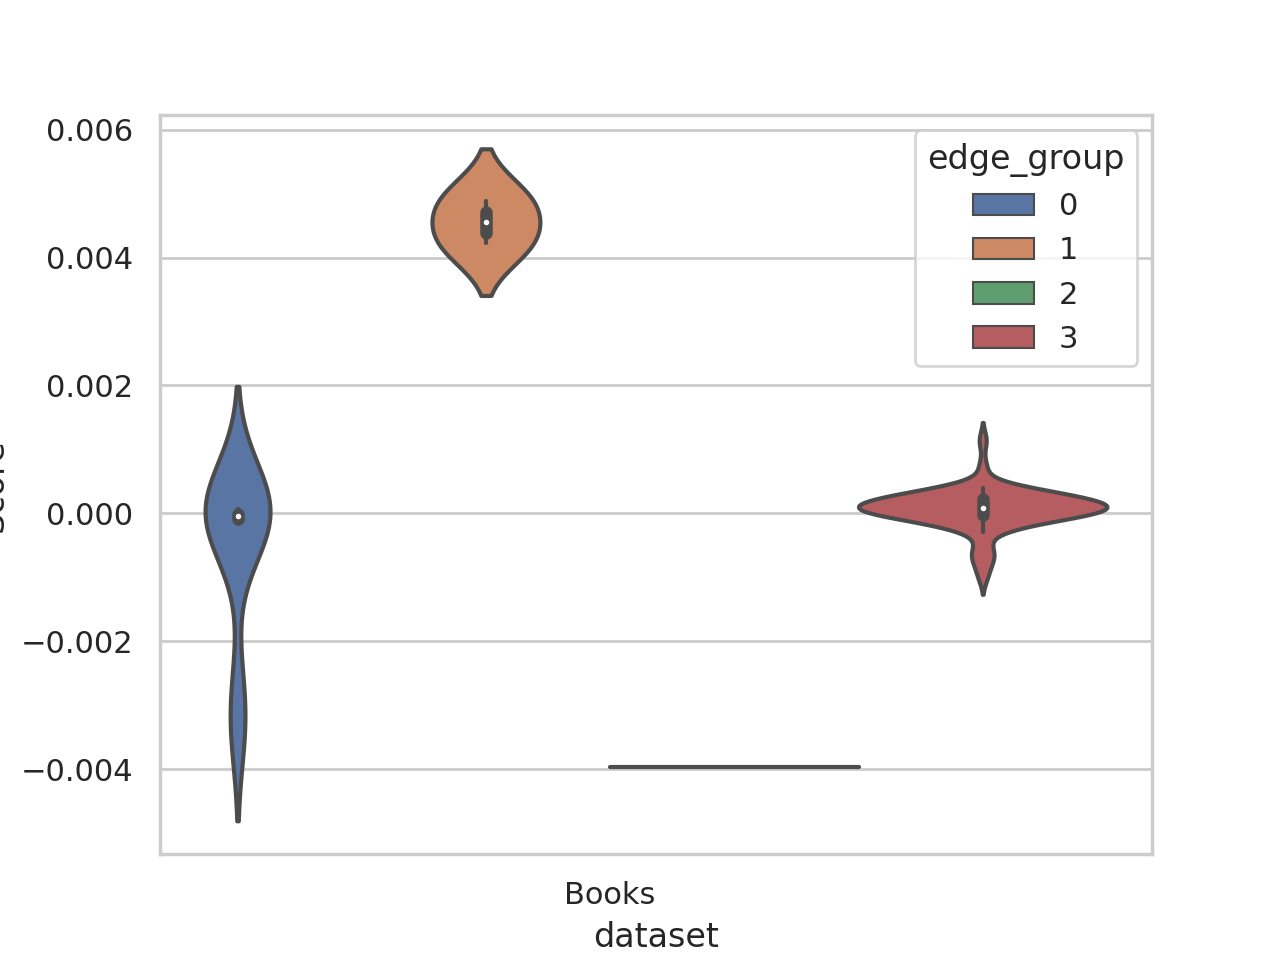

In [156]:
# sns.barplot(x="dataset", y="Score", hue="edge_group", data=books_t)
# sns.boxplot(x="dataset", y="Score", hue="edge_group", data=books_t)
sns.violinplot(x="dataset", y="Score", hue="edge_group", data=books_t)

<IPython.core.display.Javascript object>


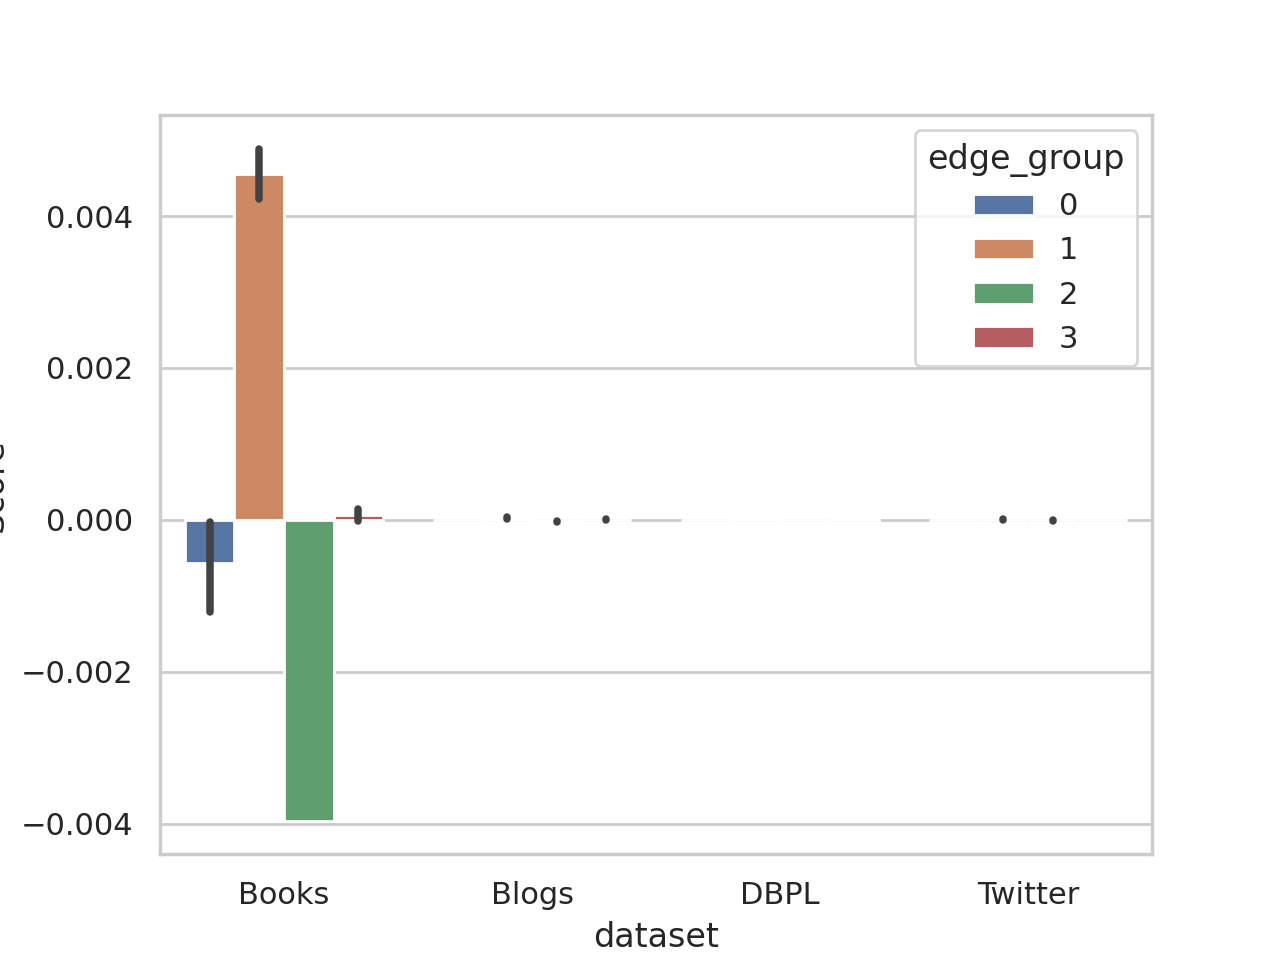

In [150]:
books_t = books.copy()
blogs_t = blogs.copy()
dblp_t = dblp.copy()
twitter_t = twitter.copy()
books_t["dataset"] = "Books"
blogs_t["dataset"] = "Blogs"
dblp_t["dataset"] = "DBPL"
twitter_t["dataset"] = "Twitter"
frames = [books_t[["Score", "edge_group", "dataset"]], blogs_t[["Score", "edge_group", "dataset"]],
          dblp_t[["Score", "edge_group", "dataset"]], twitter_t[["Score", "edge_group", "dataset"]]]
df = pd.concat(frames)
sns.barplot(x="dataset", y="Score", hue="edge_group", data=df)

In [60]:
twitter.loc[twitter.Score < 0].Distance.value_counts()

inf    1554
4.0     170
3.0     139
5.0     110
2.0      78
6.0      38
1.0      32
7.0      16
8.0       9
9.0       2
Name: Distance, dtype: int64

In [61]:
twitter.loc[twitter.Score > 0].Distance.value_counts()

inf     1609
3.0      133
4.0      129
5.0       96
2.0       67
6.0       50
1.0       46
7.0       18
8.0        8
11.0       1
Name: Distance, dtype: int64

# Books

In [64]:
print(books.corr(method="pearson").Score)

Source                         0.000290
Target                        -0.020737
Score                          1.000000
pagerank_source               -0.003073
redPagerank_source            -0.001767
group_source                  -0.002593
inDegree_source               -0.003128
outDegree_source              -0.003128
redNeighborsInRatio_source    -0.001575
redNeighborsOutRatio_source   -0.001575
out_homophily_source          -0.004852
pagerank_target                0.158349
redPagerank_target             0.337649
group_target                   0.363713
inDegree_target                0.168272
outDegree_target               0.168272
redNeighborsInRatio_target     0.344939
redNeighborsOutRatio_target    0.344939
out_homophily_target           0.096351
red_pagerank_dif               0.978057
edge_group                     0.120742
Distance                            NaN
Name: Score, dtype: float64


In [65]:
print(books.corr(method="spearman").Score)

Source                         0.162531
Target                        -0.090265
Score                          1.000000
pagerank_source                0.117448
redPagerank_source            -0.073384
group_source                   0.169286
inDegree_source                0.114398
outDegree_source               0.114398
redNeighborsInRatio_source    -0.082095
redNeighborsOutRatio_source   -0.082095
out_homophily_source          -0.342754
pagerank_target               -0.002450
redPagerank_target             0.450257
group_target                   0.325998
inDegree_target                0.018261
outDegree_target               0.018261
redNeighborsInRatio_target     0.515680
redNeighborsOutRatio_target    0.515680
out_homophily_target           0.290936
red_pagerank_dif               0.956792
edge_group                     0.231115
Distance                            NaN
Name: Score, dtype: float64


Source and target destination matter. As expected.

<IPython.core.display.Javascript object>


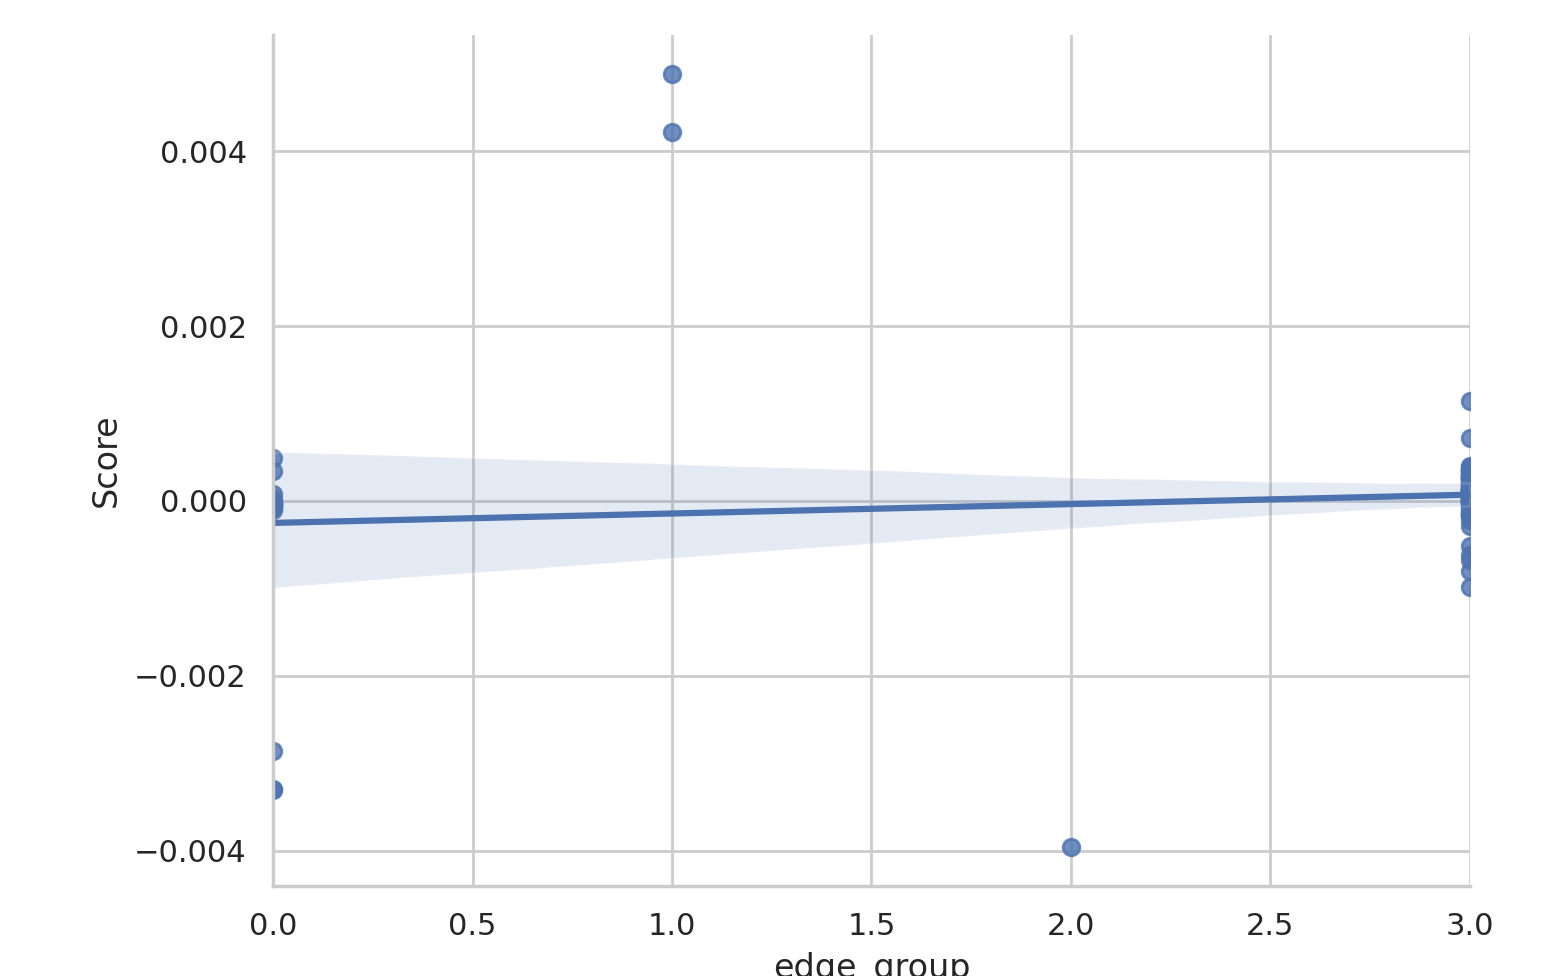

In [48]:
sns.lmplot(x="edge_group",y="Score", data=books)

As expected red neighbors out ratio matters because is a good correlation metric for red pagerank of the target.

<IPython.core.display.Javascript object>


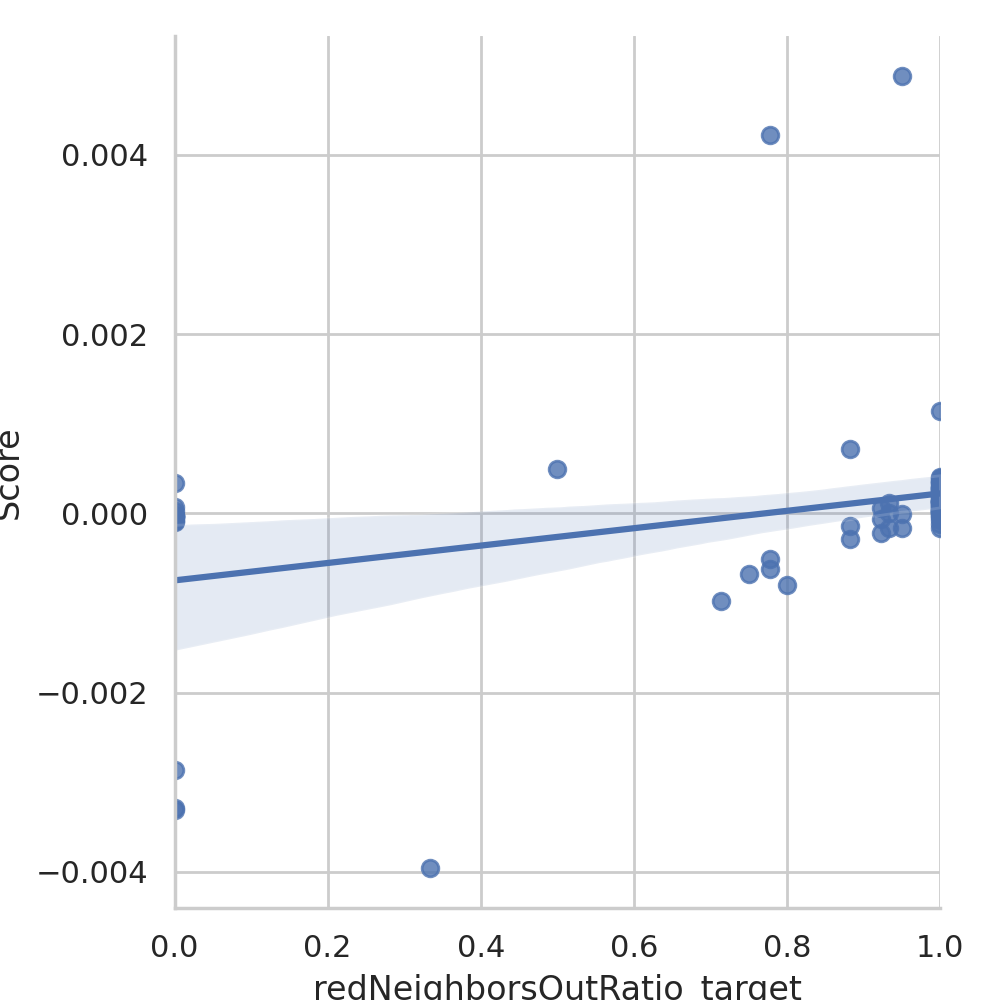

In [70]:
sns.lmplot(x="redNeighborsOutRatio_target",y="Score", data=books)

<IPython.core.display.Javascript object>


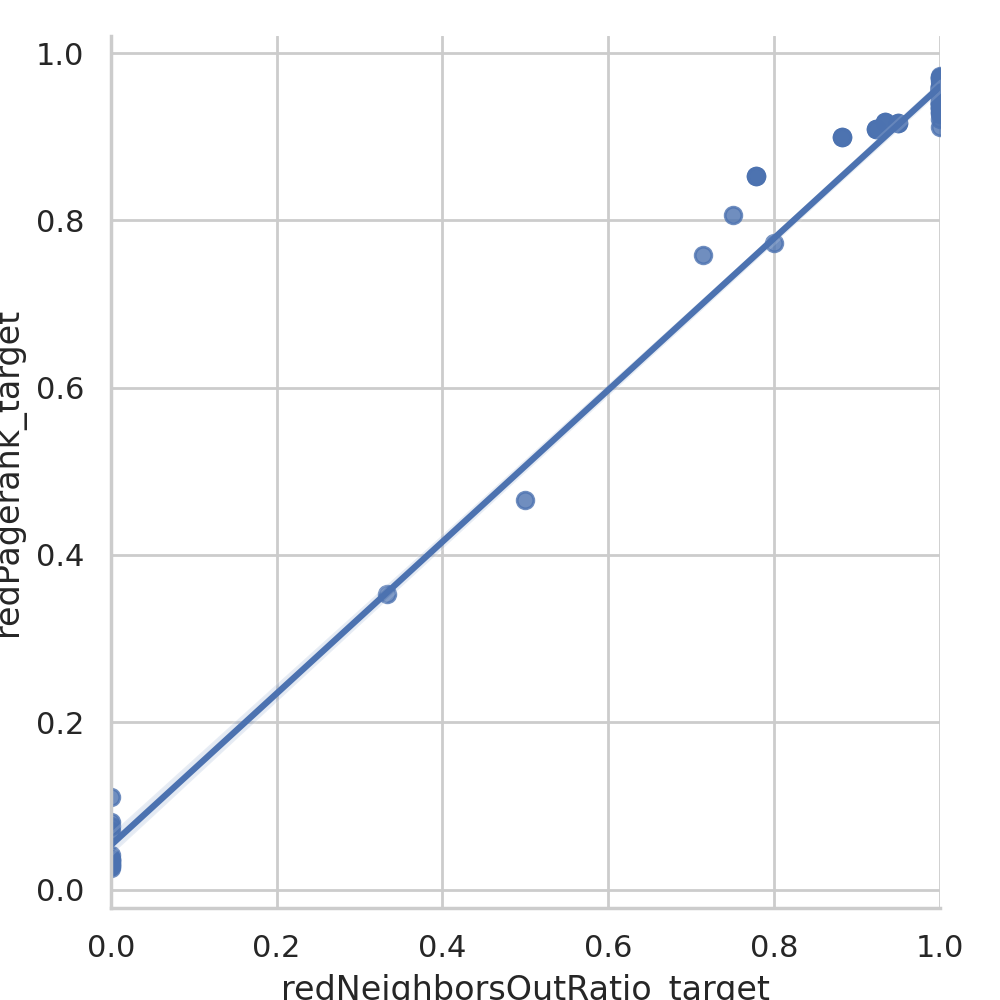

In [71]:
sns.lmplot(x="redNeighborsOutRatio_target",y="redPagerank_target", data=books)

As expected the lower the out degree the greatest the change as more pagerank quantity is redirected.

<IPython.core.display.Javascript object>


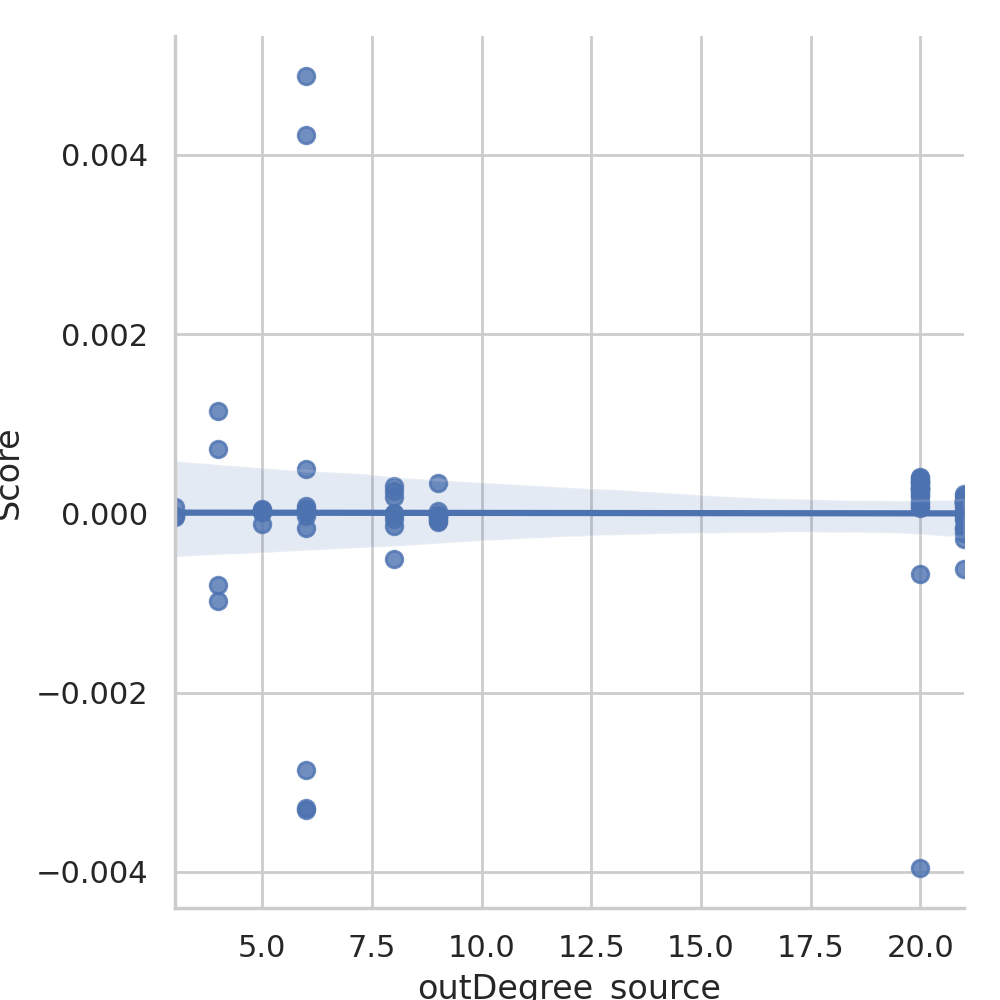

In [72]:
sns.lmplot(x="outDegree_source",y="Score", data=books)

Naturally targets category matters. We expect red nodes favour red group

<IPython.core.display.Javascript object>


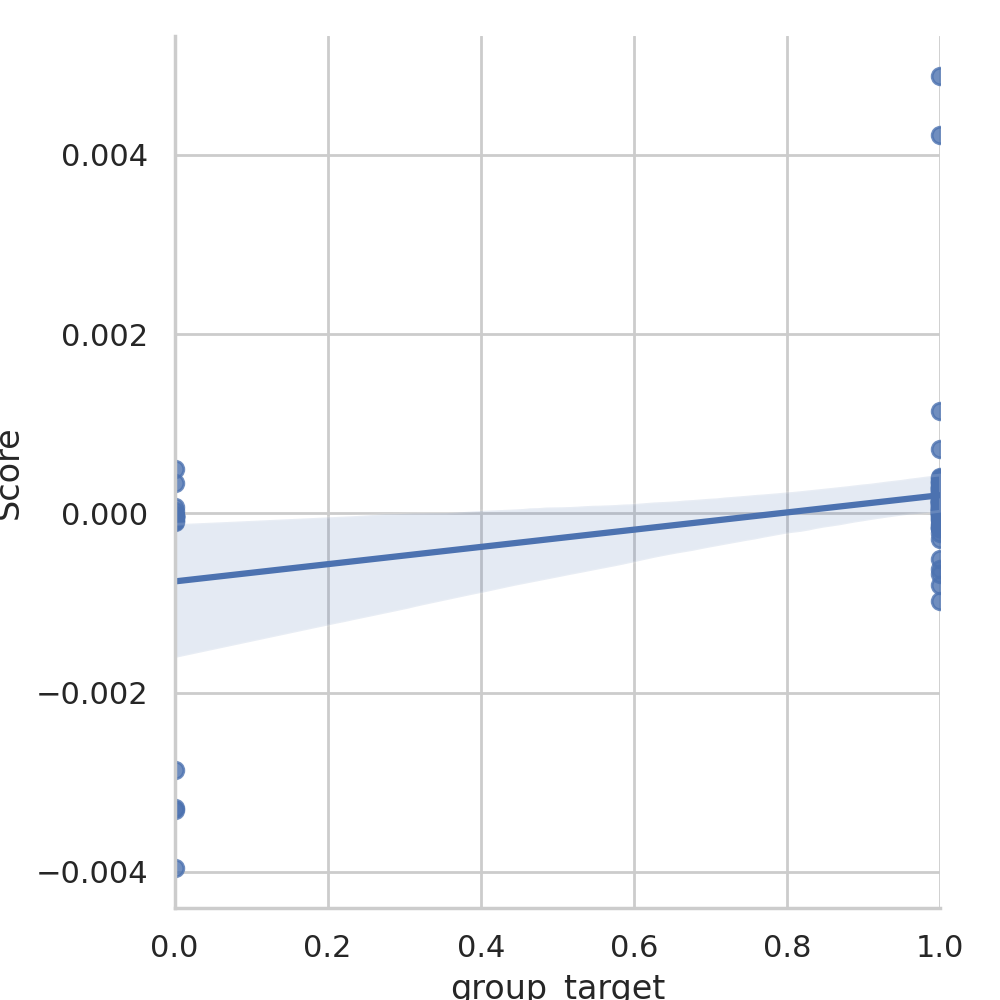

In [73]:
sns.lmplot(x="group_target",y="Score", data=books)

It is the difference in red pagerank between source and target that matters most.

<IPython.core.display.Javascript object>


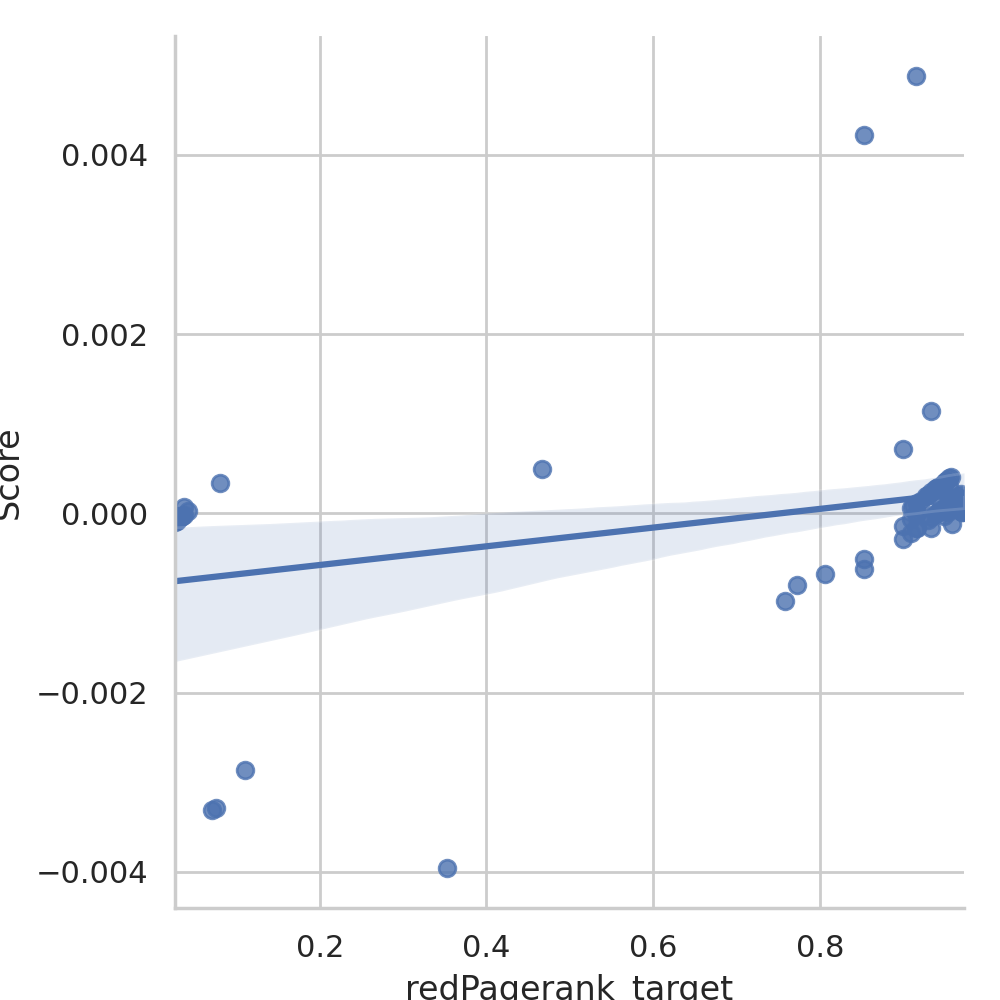

In [74]:
sns.lmplot(x="redPagerank_target",y="Score", data=books)

<IPython.core.display.Javascript object>


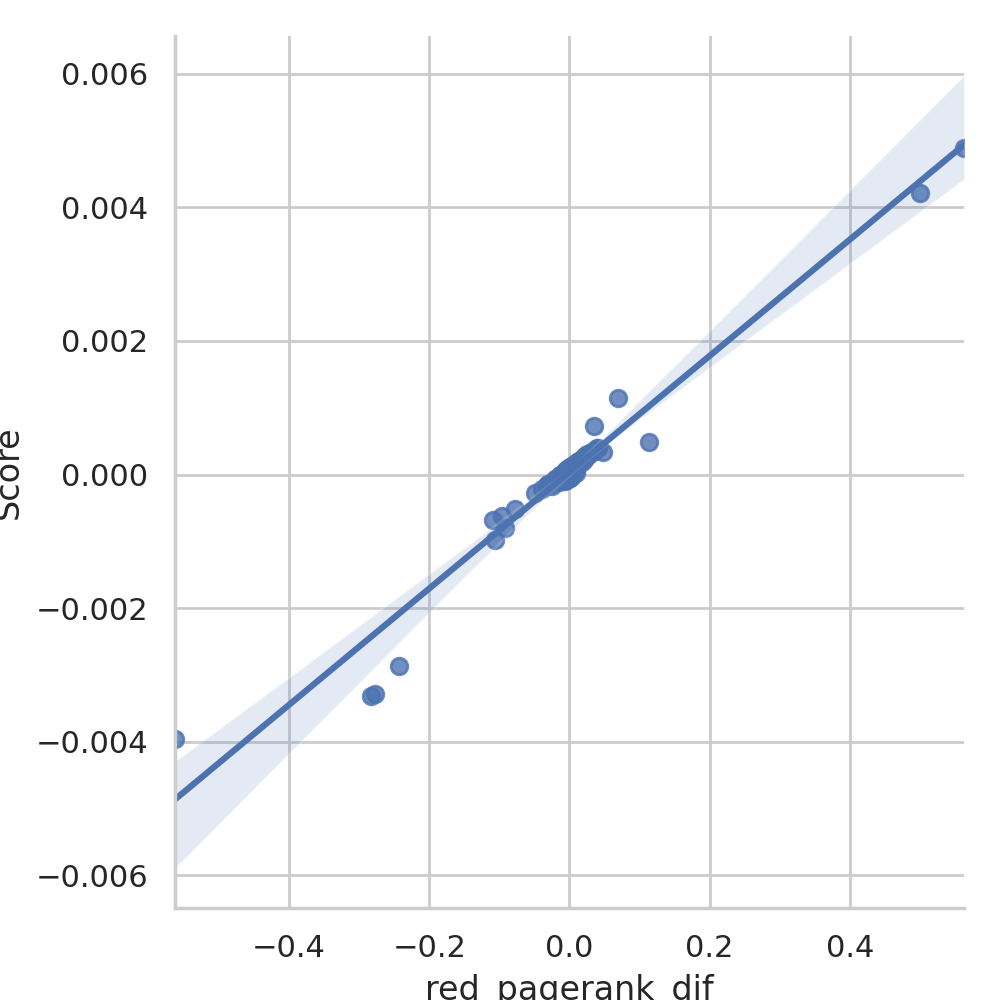

In [75]:
sns.lmplot(x="red_pagerank_dif",y="Score", data=books)

<IPython.core.display.Javascript object>


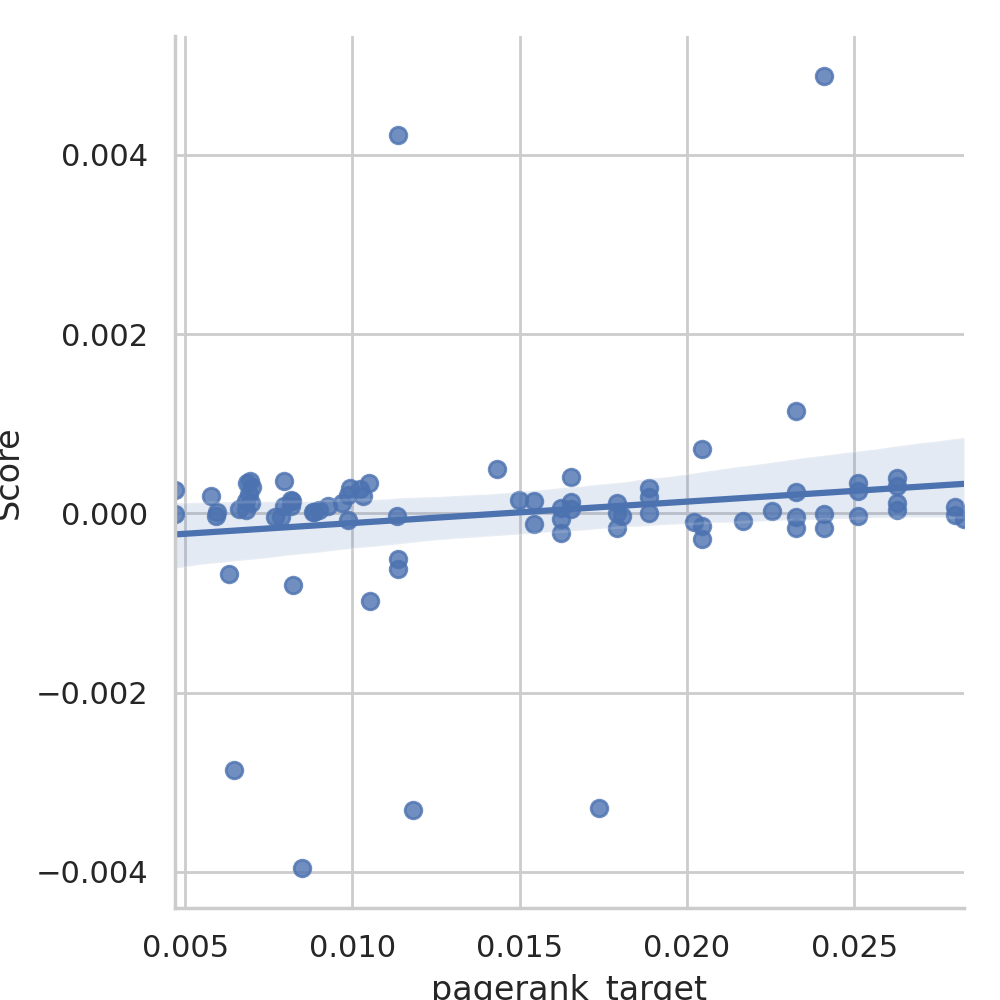

In [76]:
sns.lmplot(x="pagerank_target",y="Score", data=books)

Naturally changes are minor in homophilic neighbors. Pagerank pretty much redirects to same category as before.

<IPython.core.display.Javascript object>


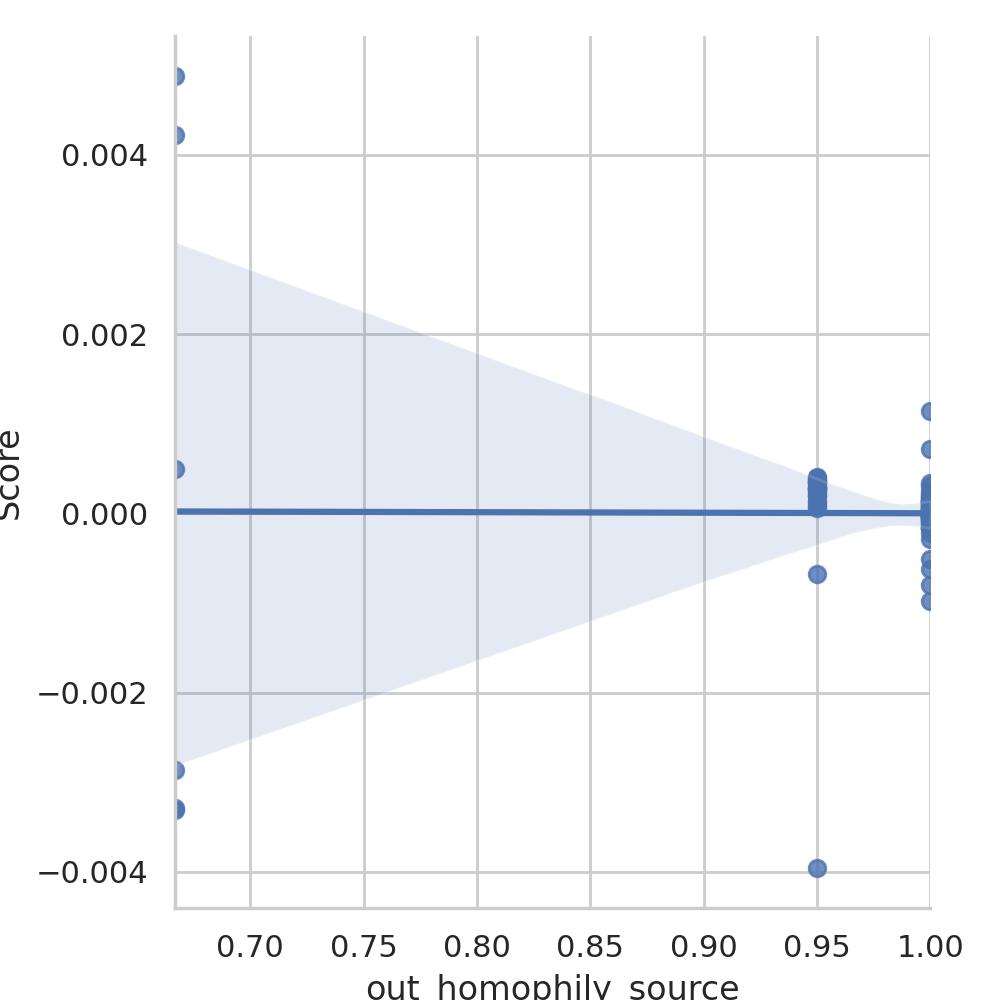

In [88]:
sns.lmplot(x="out_homophily_source",y="Score", data=books)

Strong or weak in red pagerank are too homophilic and the removal of an edge doesn't affect fairness. Weak in pagerank have naturally low impact.

<IPython.core.display.Javascript object>


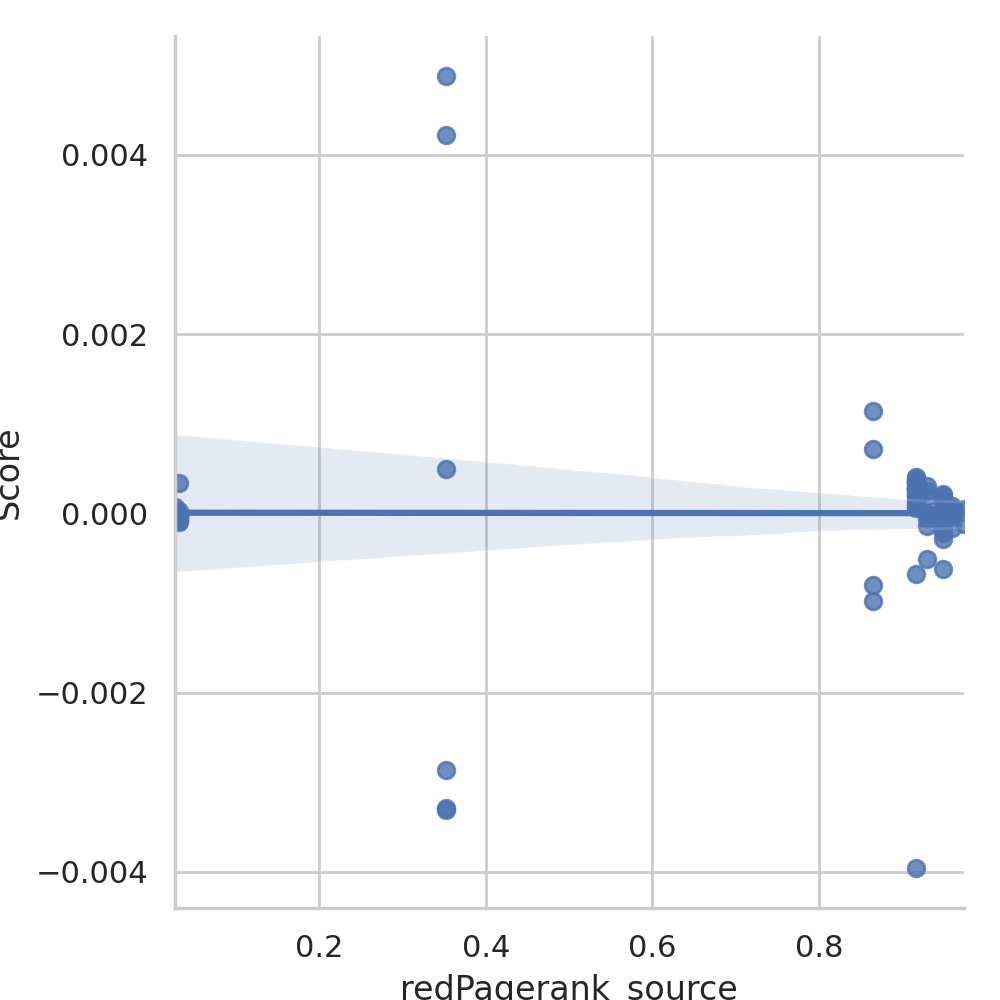

In [78]:
sns.lmplot(x="redPagerank_source",y="Score", data=books)

As expected red neighbors out ratio matters because is a good correlation metric for red pagerank of the target.

# Blogs

<IPython.core.display.Javascript object>


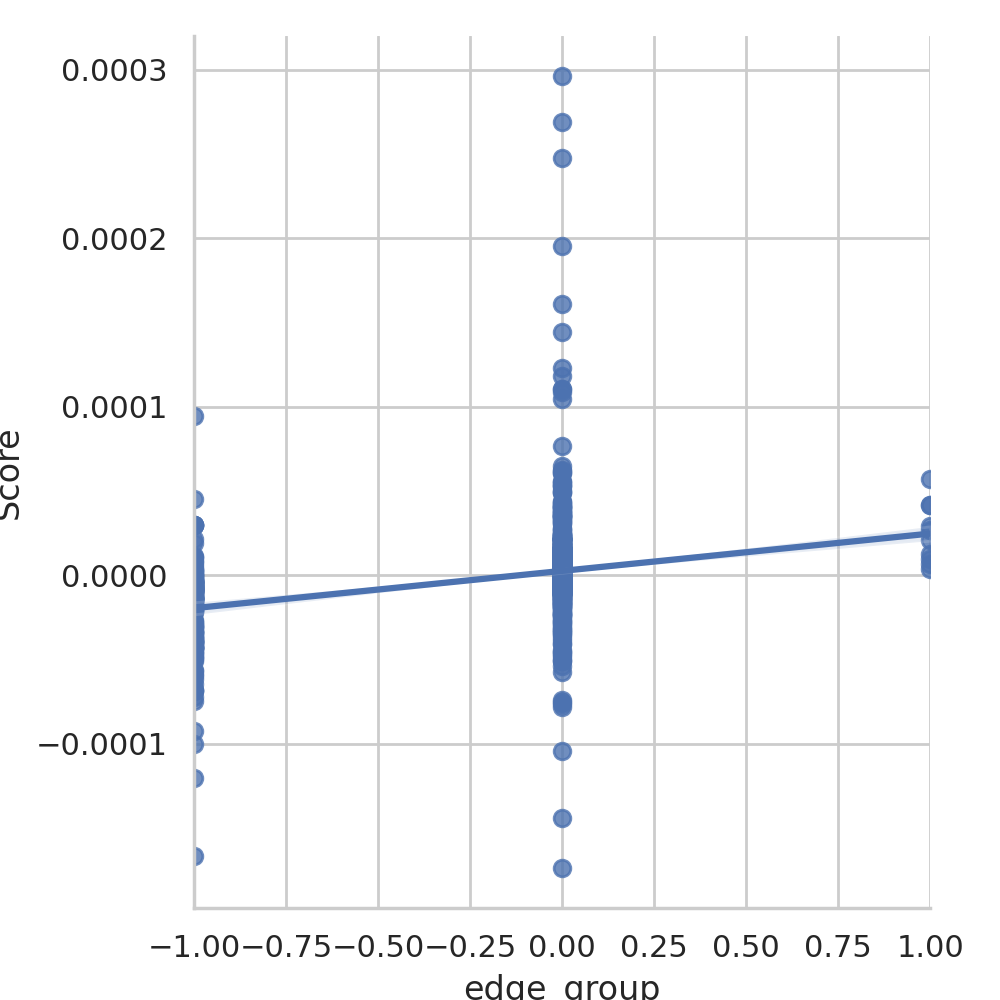

In [113]:
sns.lmplot(x="edge_group",y="Score", data=blogs)

<IPython.core.display.Javascript object>


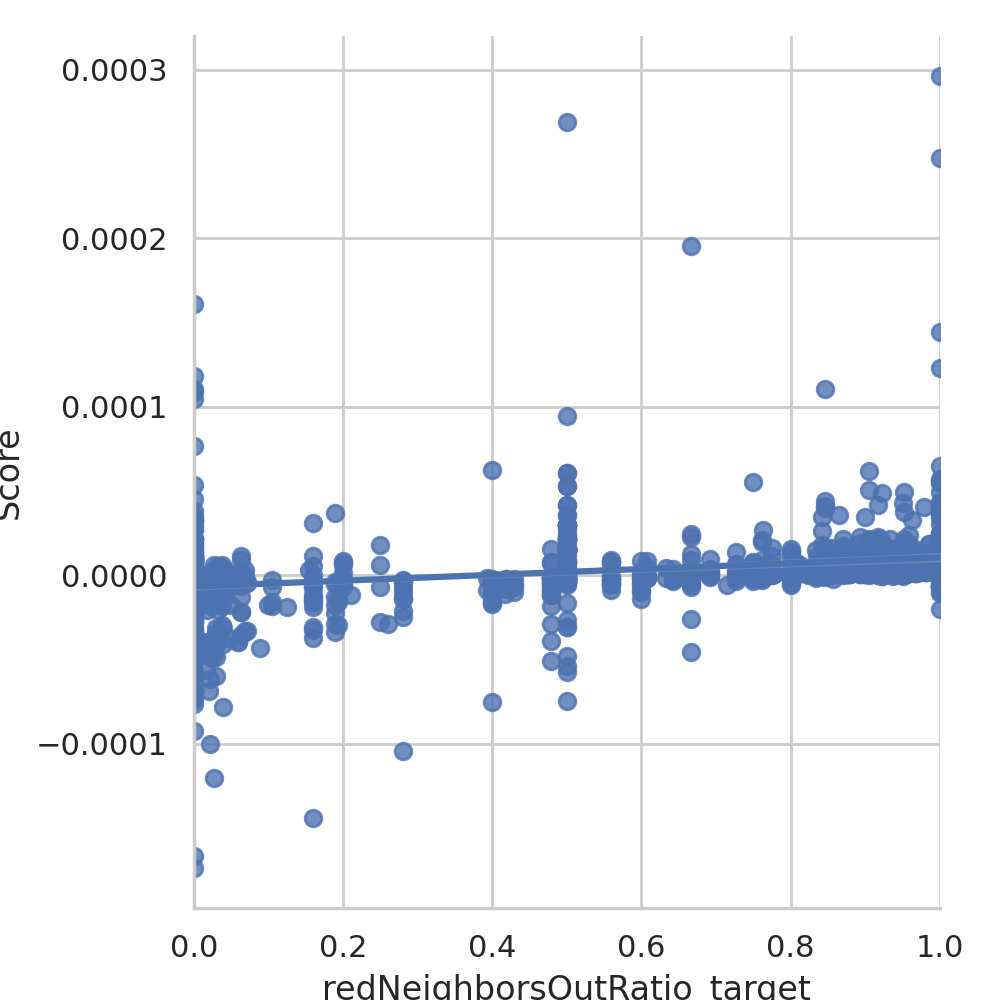

In [79]:
sns.lmplot(x="redNeighborsOutRatio_target",y="Score", data=blogs)

<IPython.core.display.Javascript object>


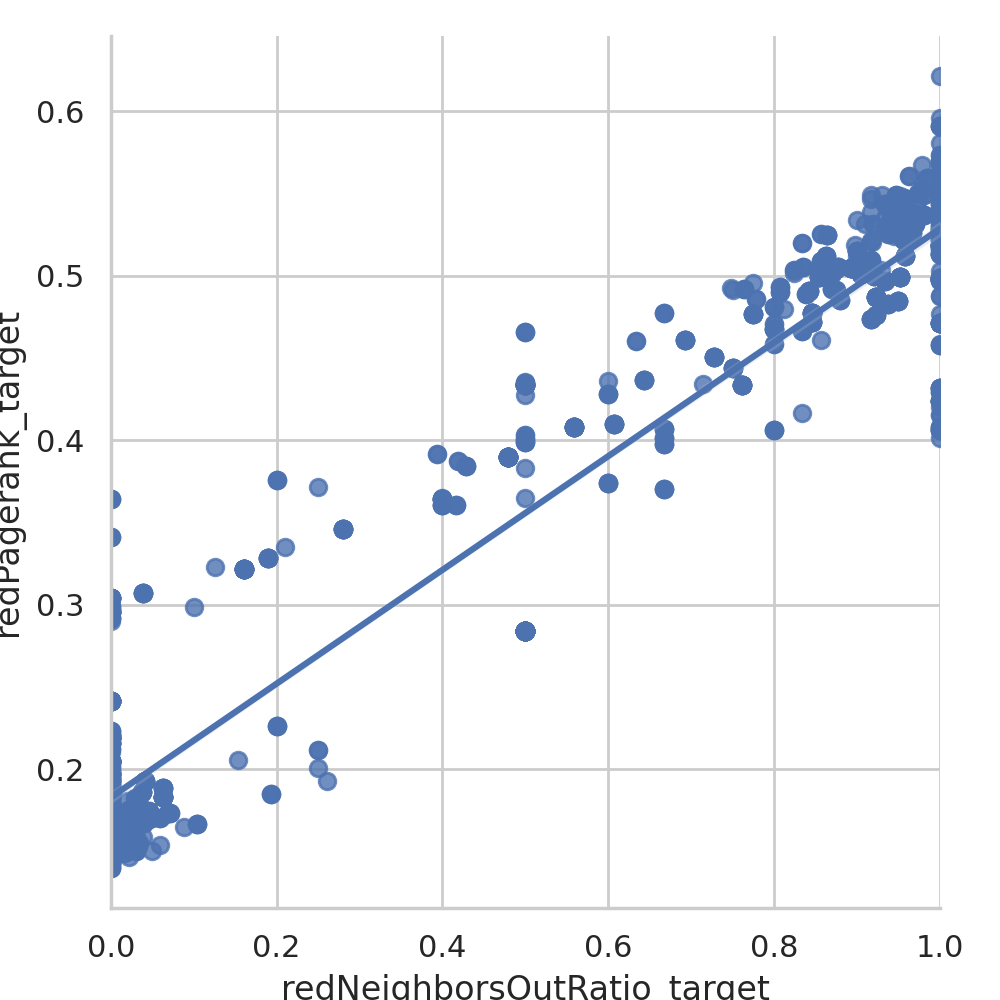

In [80]:
sns.lmplot(x="redNeighborsOutRatio_target",y="redPagerank_target", data=blogs)

As expected the lower the out degree the greatest the change as more pagerank quantity is redirected.

<IPython.core.display.Javascript object>


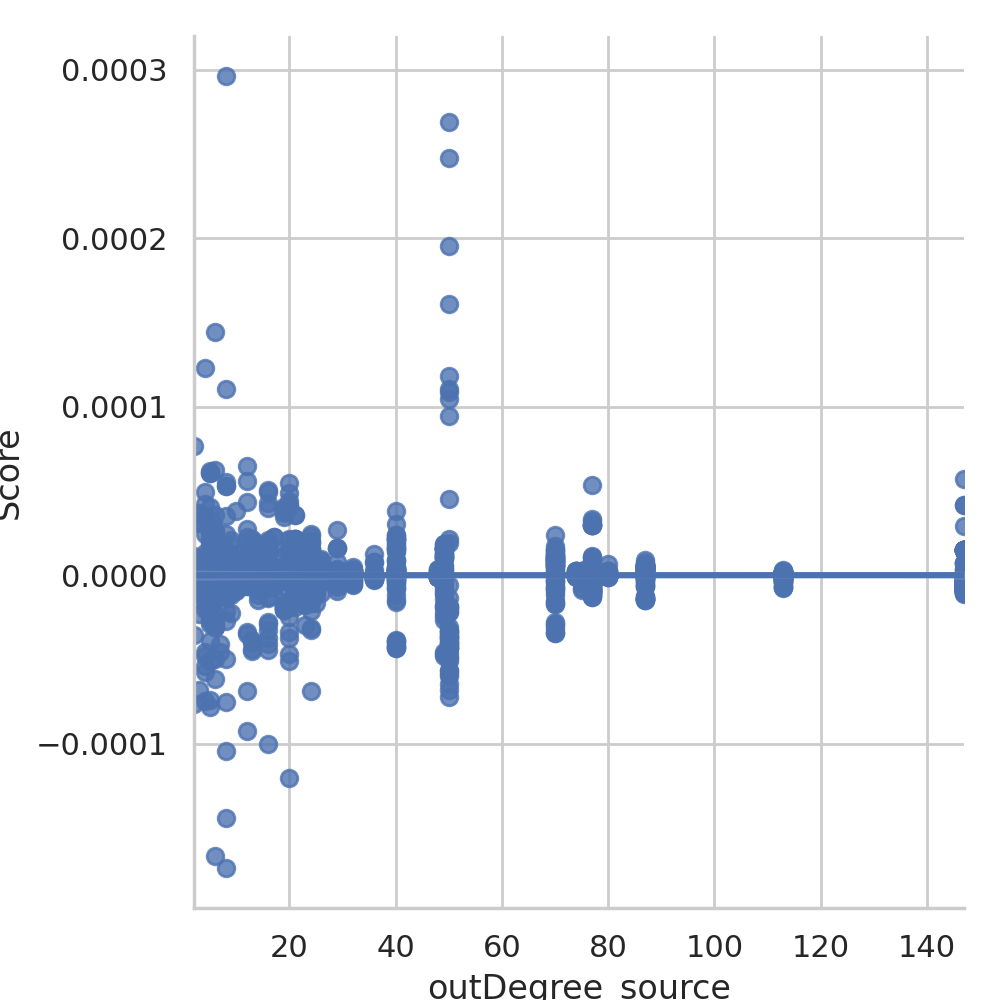

In [81]:
sns.lmplot(x="outDegree_source",y="Score", data=blogs)

Naturally targets category matters. We expect red nodes favour red group

<IPython.core.display.Javascript object>


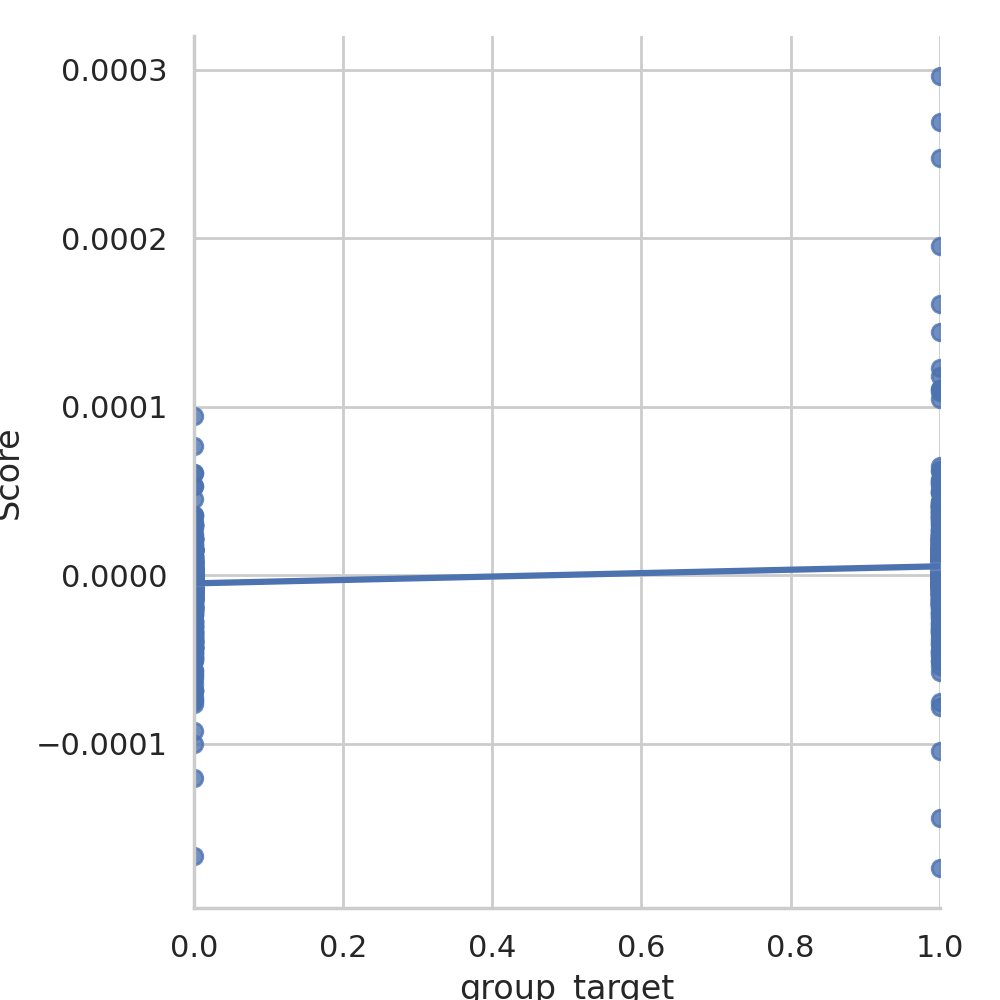

In [82]:
sns.lmplot(x="group_target",y="Score", data=blogs)

It is the difference in red pagerank between source and target that matters most.

<IPython.core.display.Javascript object>


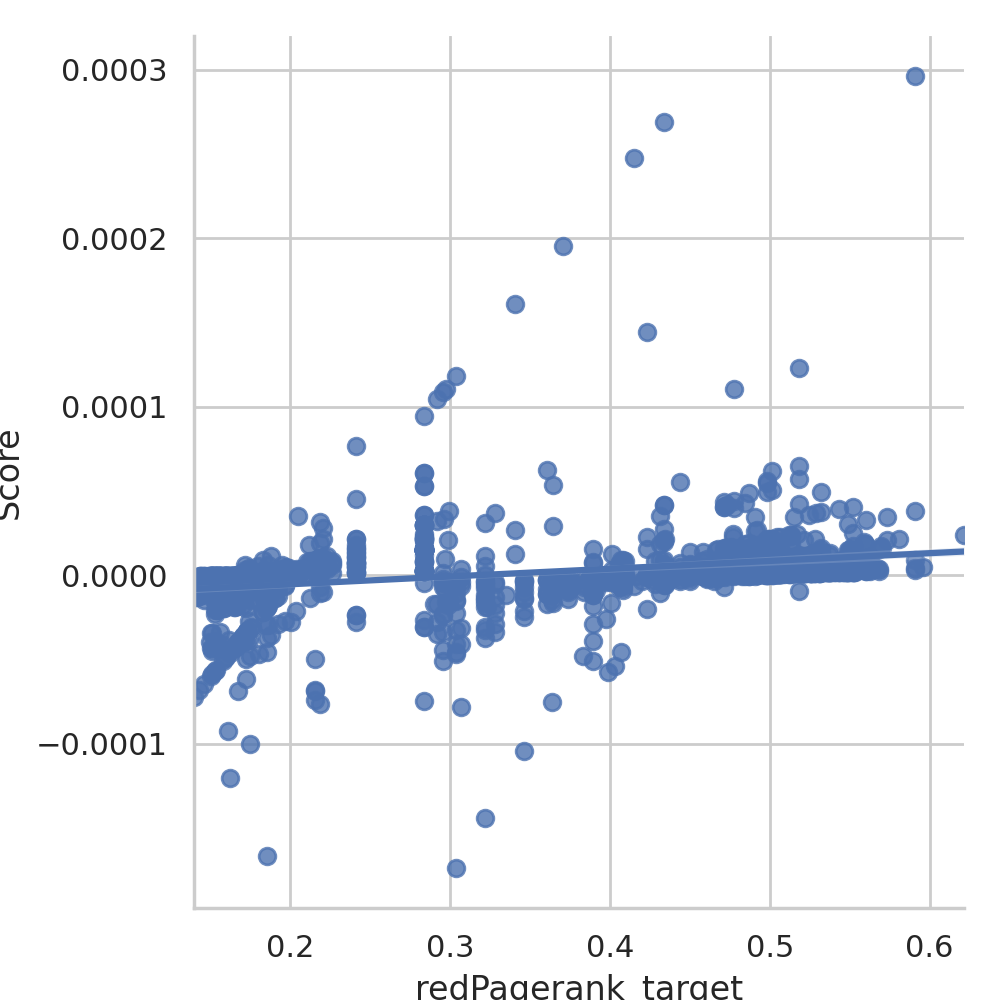

In [83]:
sns.lmplot(x="redPagerank_target",y="Score", data=blogs)

<IPython.core.display.Javascript object>


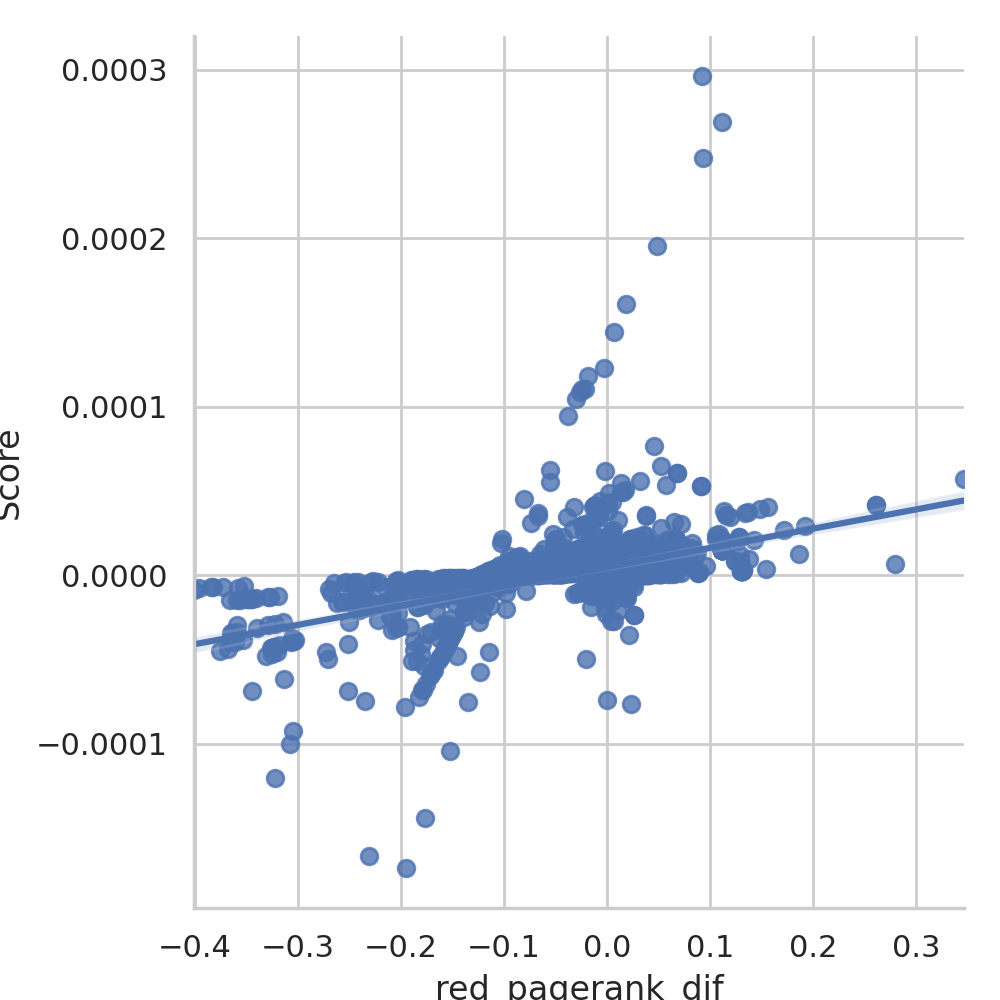

In [84]:
sns.lmplot(x="red_pagerank_dif",y="Score", data=blogs)

<IPython.core.display.Javascript object>


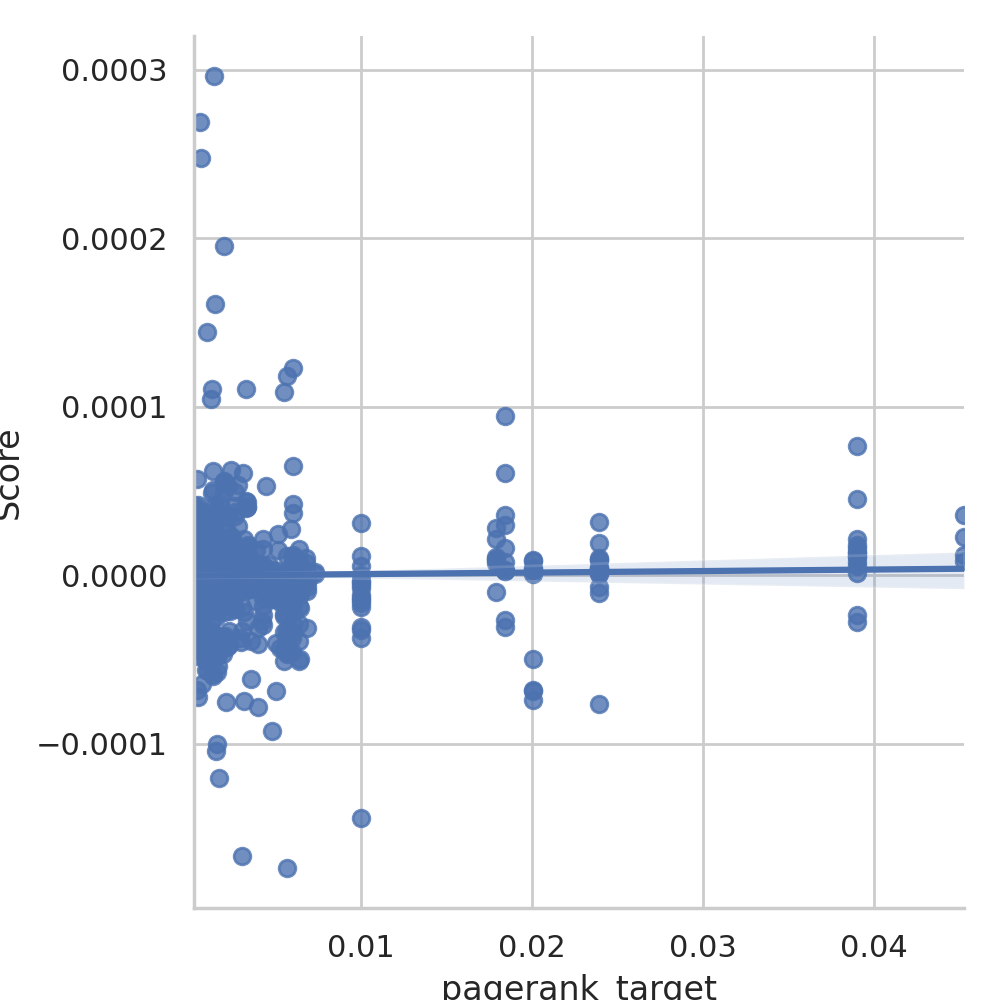

In [85]:
sns.lmplot(x="pagerank_target",y="Score", data=blogs)

Naturally changes are minor in homophilic neighbors. Pagerank pretty much redirects to same category as before.

<IPython.core.display.Javascript object>


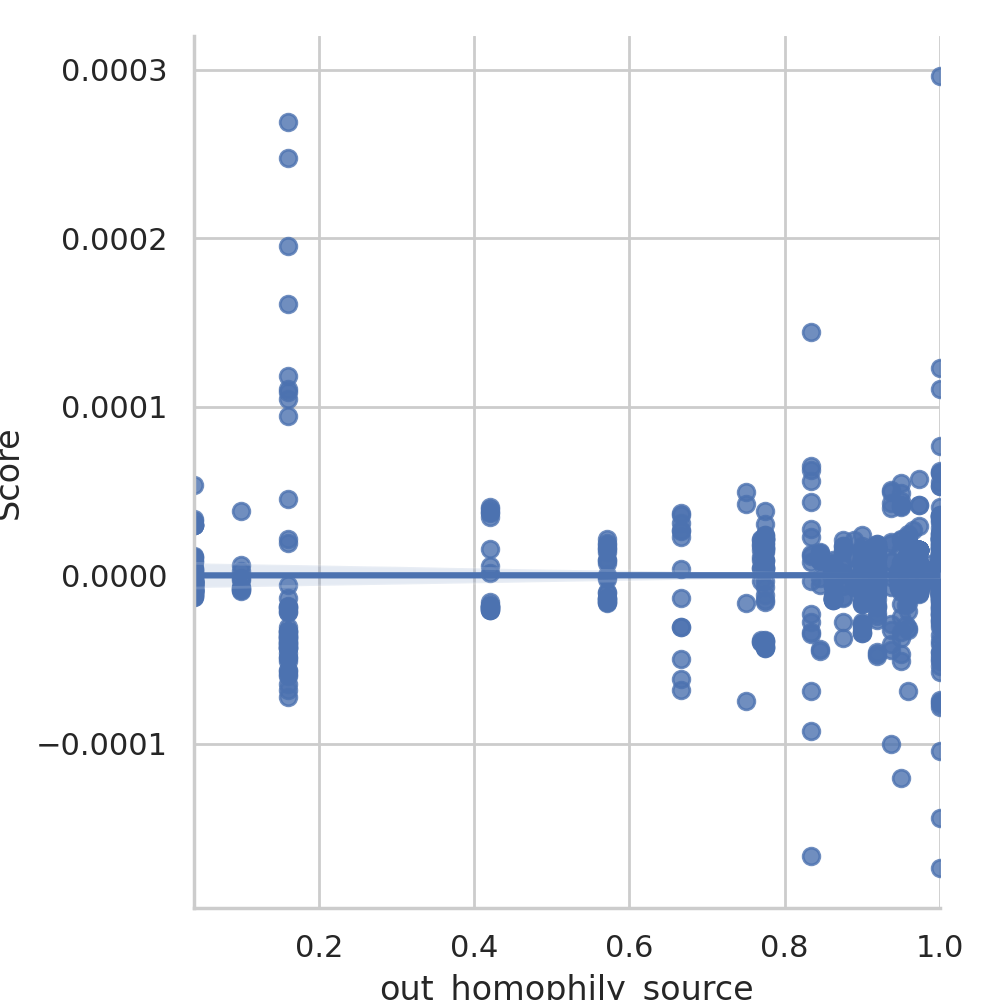

In [86]:
sns.lmplot(x="out_homophily_source",y="Score", data=blogs)

Strong or weak in red pagerank are too homophilic and the removal of an edge doesn't affect fairness. Weak in pagerank have naturally low impact.

<IPython.core.display.Javascript object>


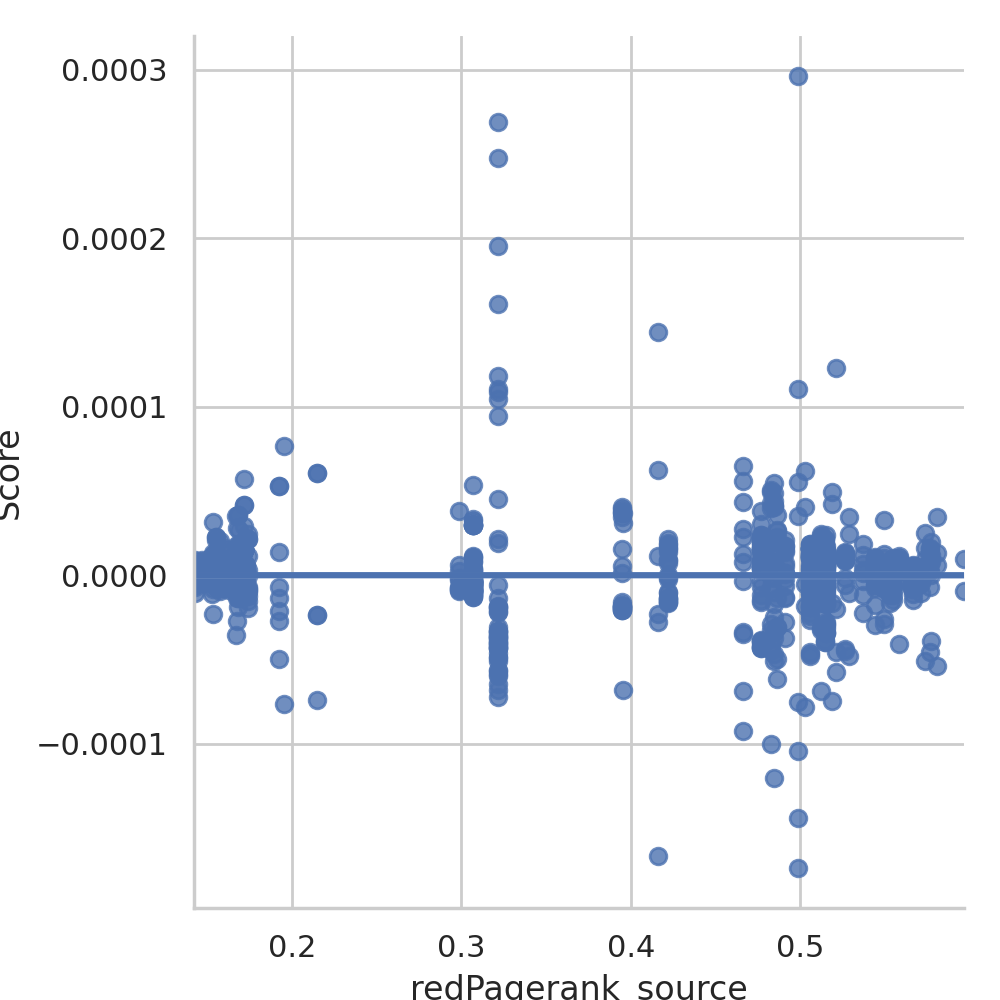

In [87]:
sns.lmplot(x="redPagerank_source",y="Score", data=blogs)

# DBLP

<IPython.core.display.Javascript object>


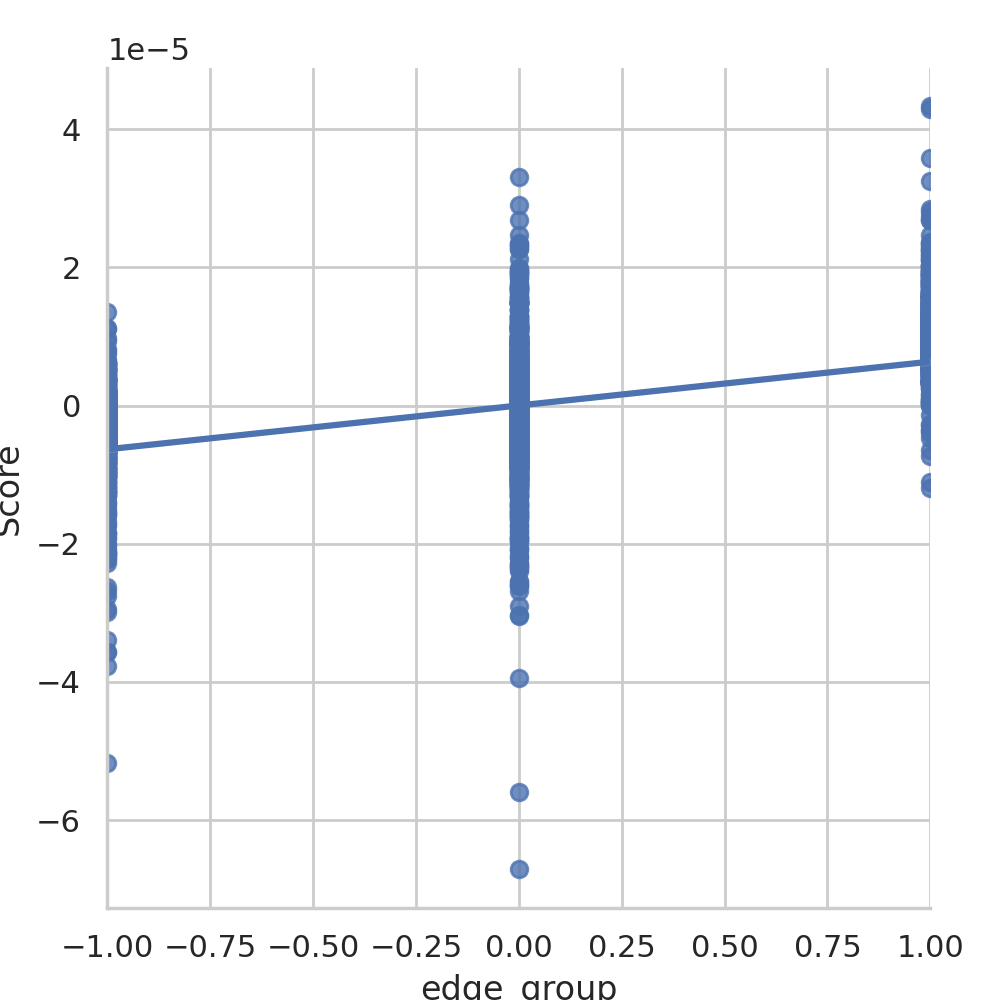

In [114]:
sns.lmplot(x="edge_group",y="Score", data=dblp)

<IPython.core.display.Javascript object>


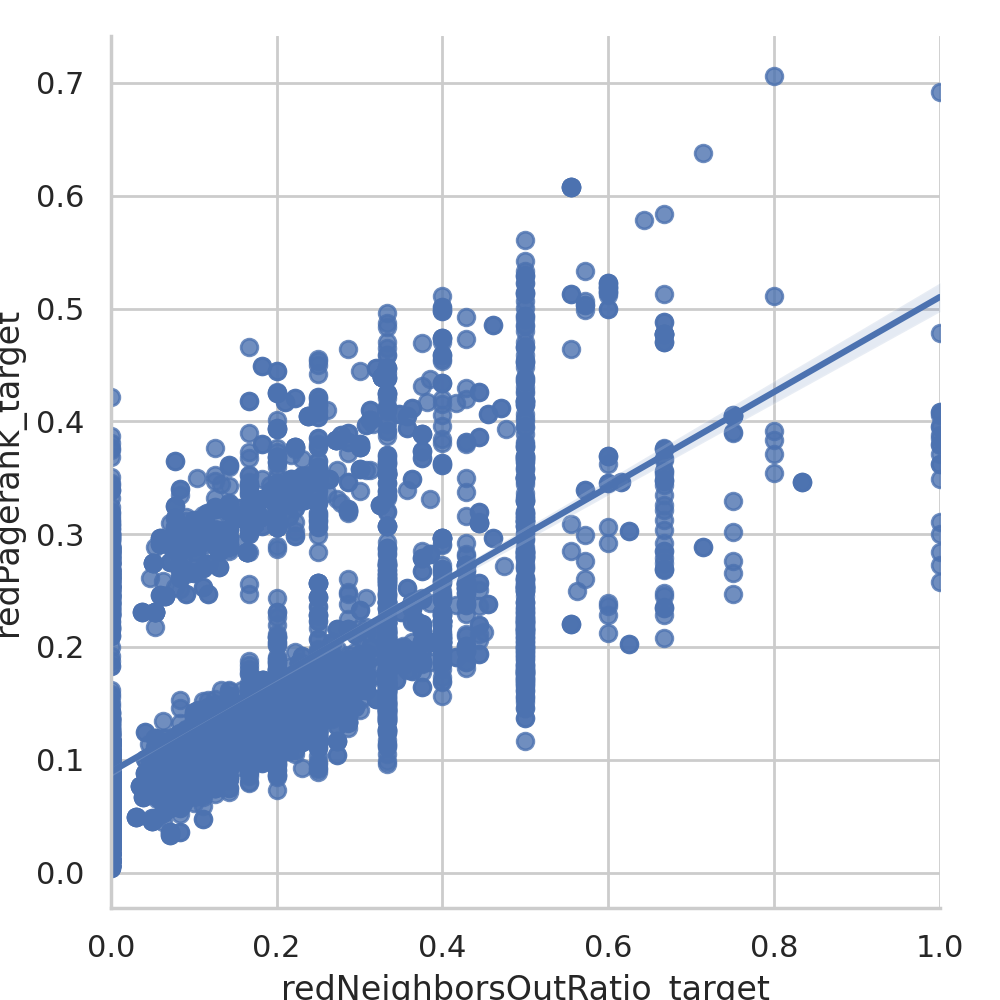

In [94]:
sns.lmplot(x="redNeighborsOutRatio_target",y="redPagerank_target", data=dblp)

<IPython.core.display.Javascript object>


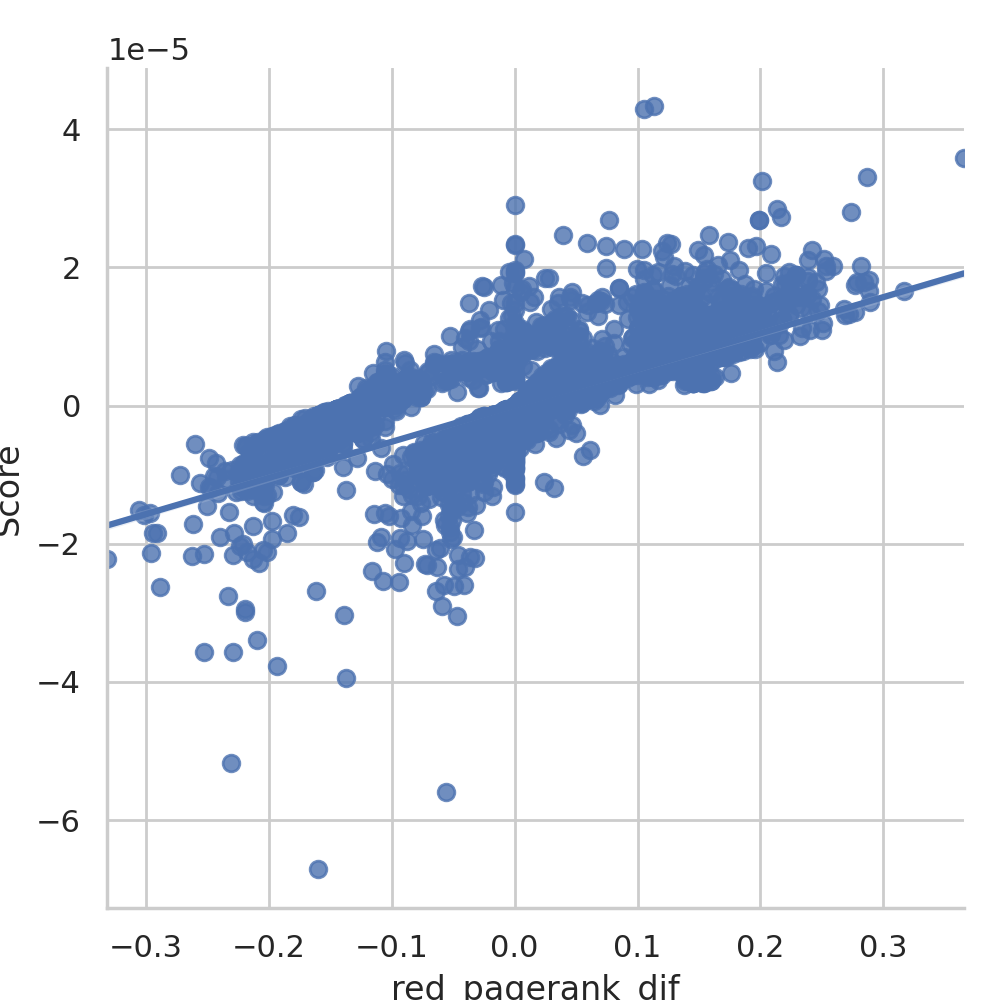

In [95]:
sns.lmplot(x="red_pagerank_dif",y="Score", data=dblp)

<IPython.core.display.Javascript object>


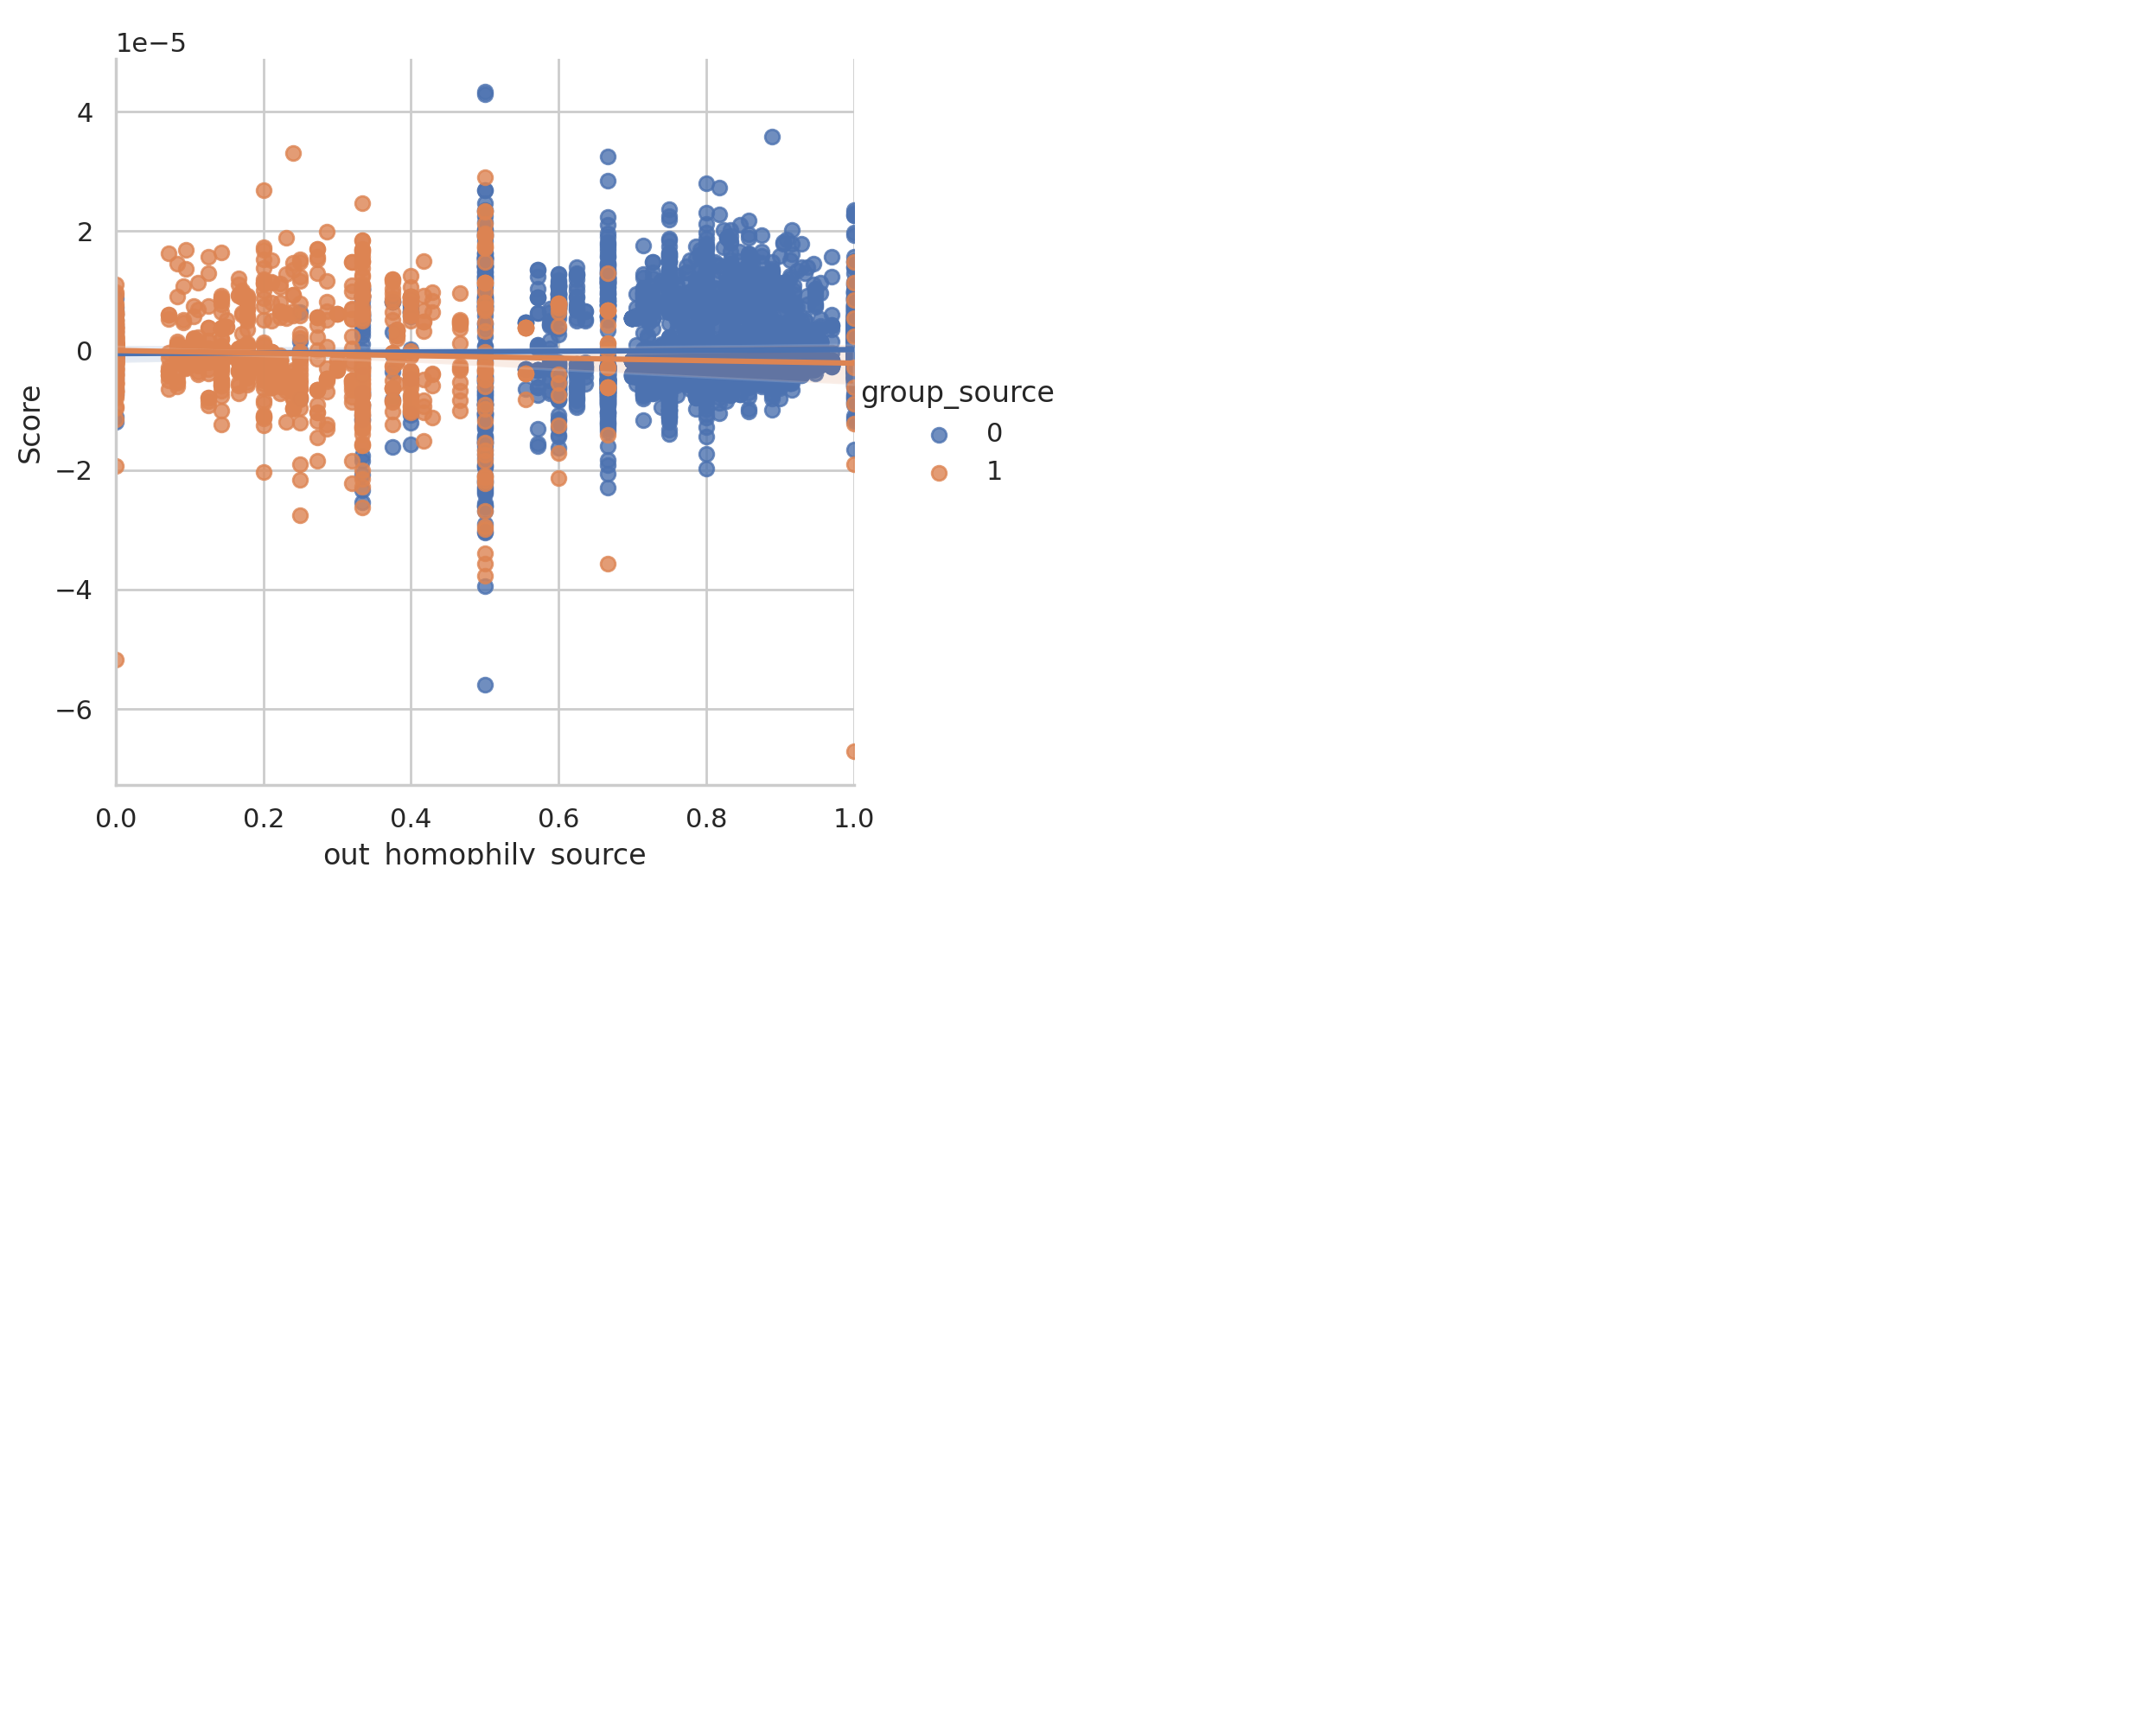

In [105]:
sns.lmplot(x="out_homophily_source",y="Score", hue="group_source", data=dblp)

<IPython.core.display.Javascript object>


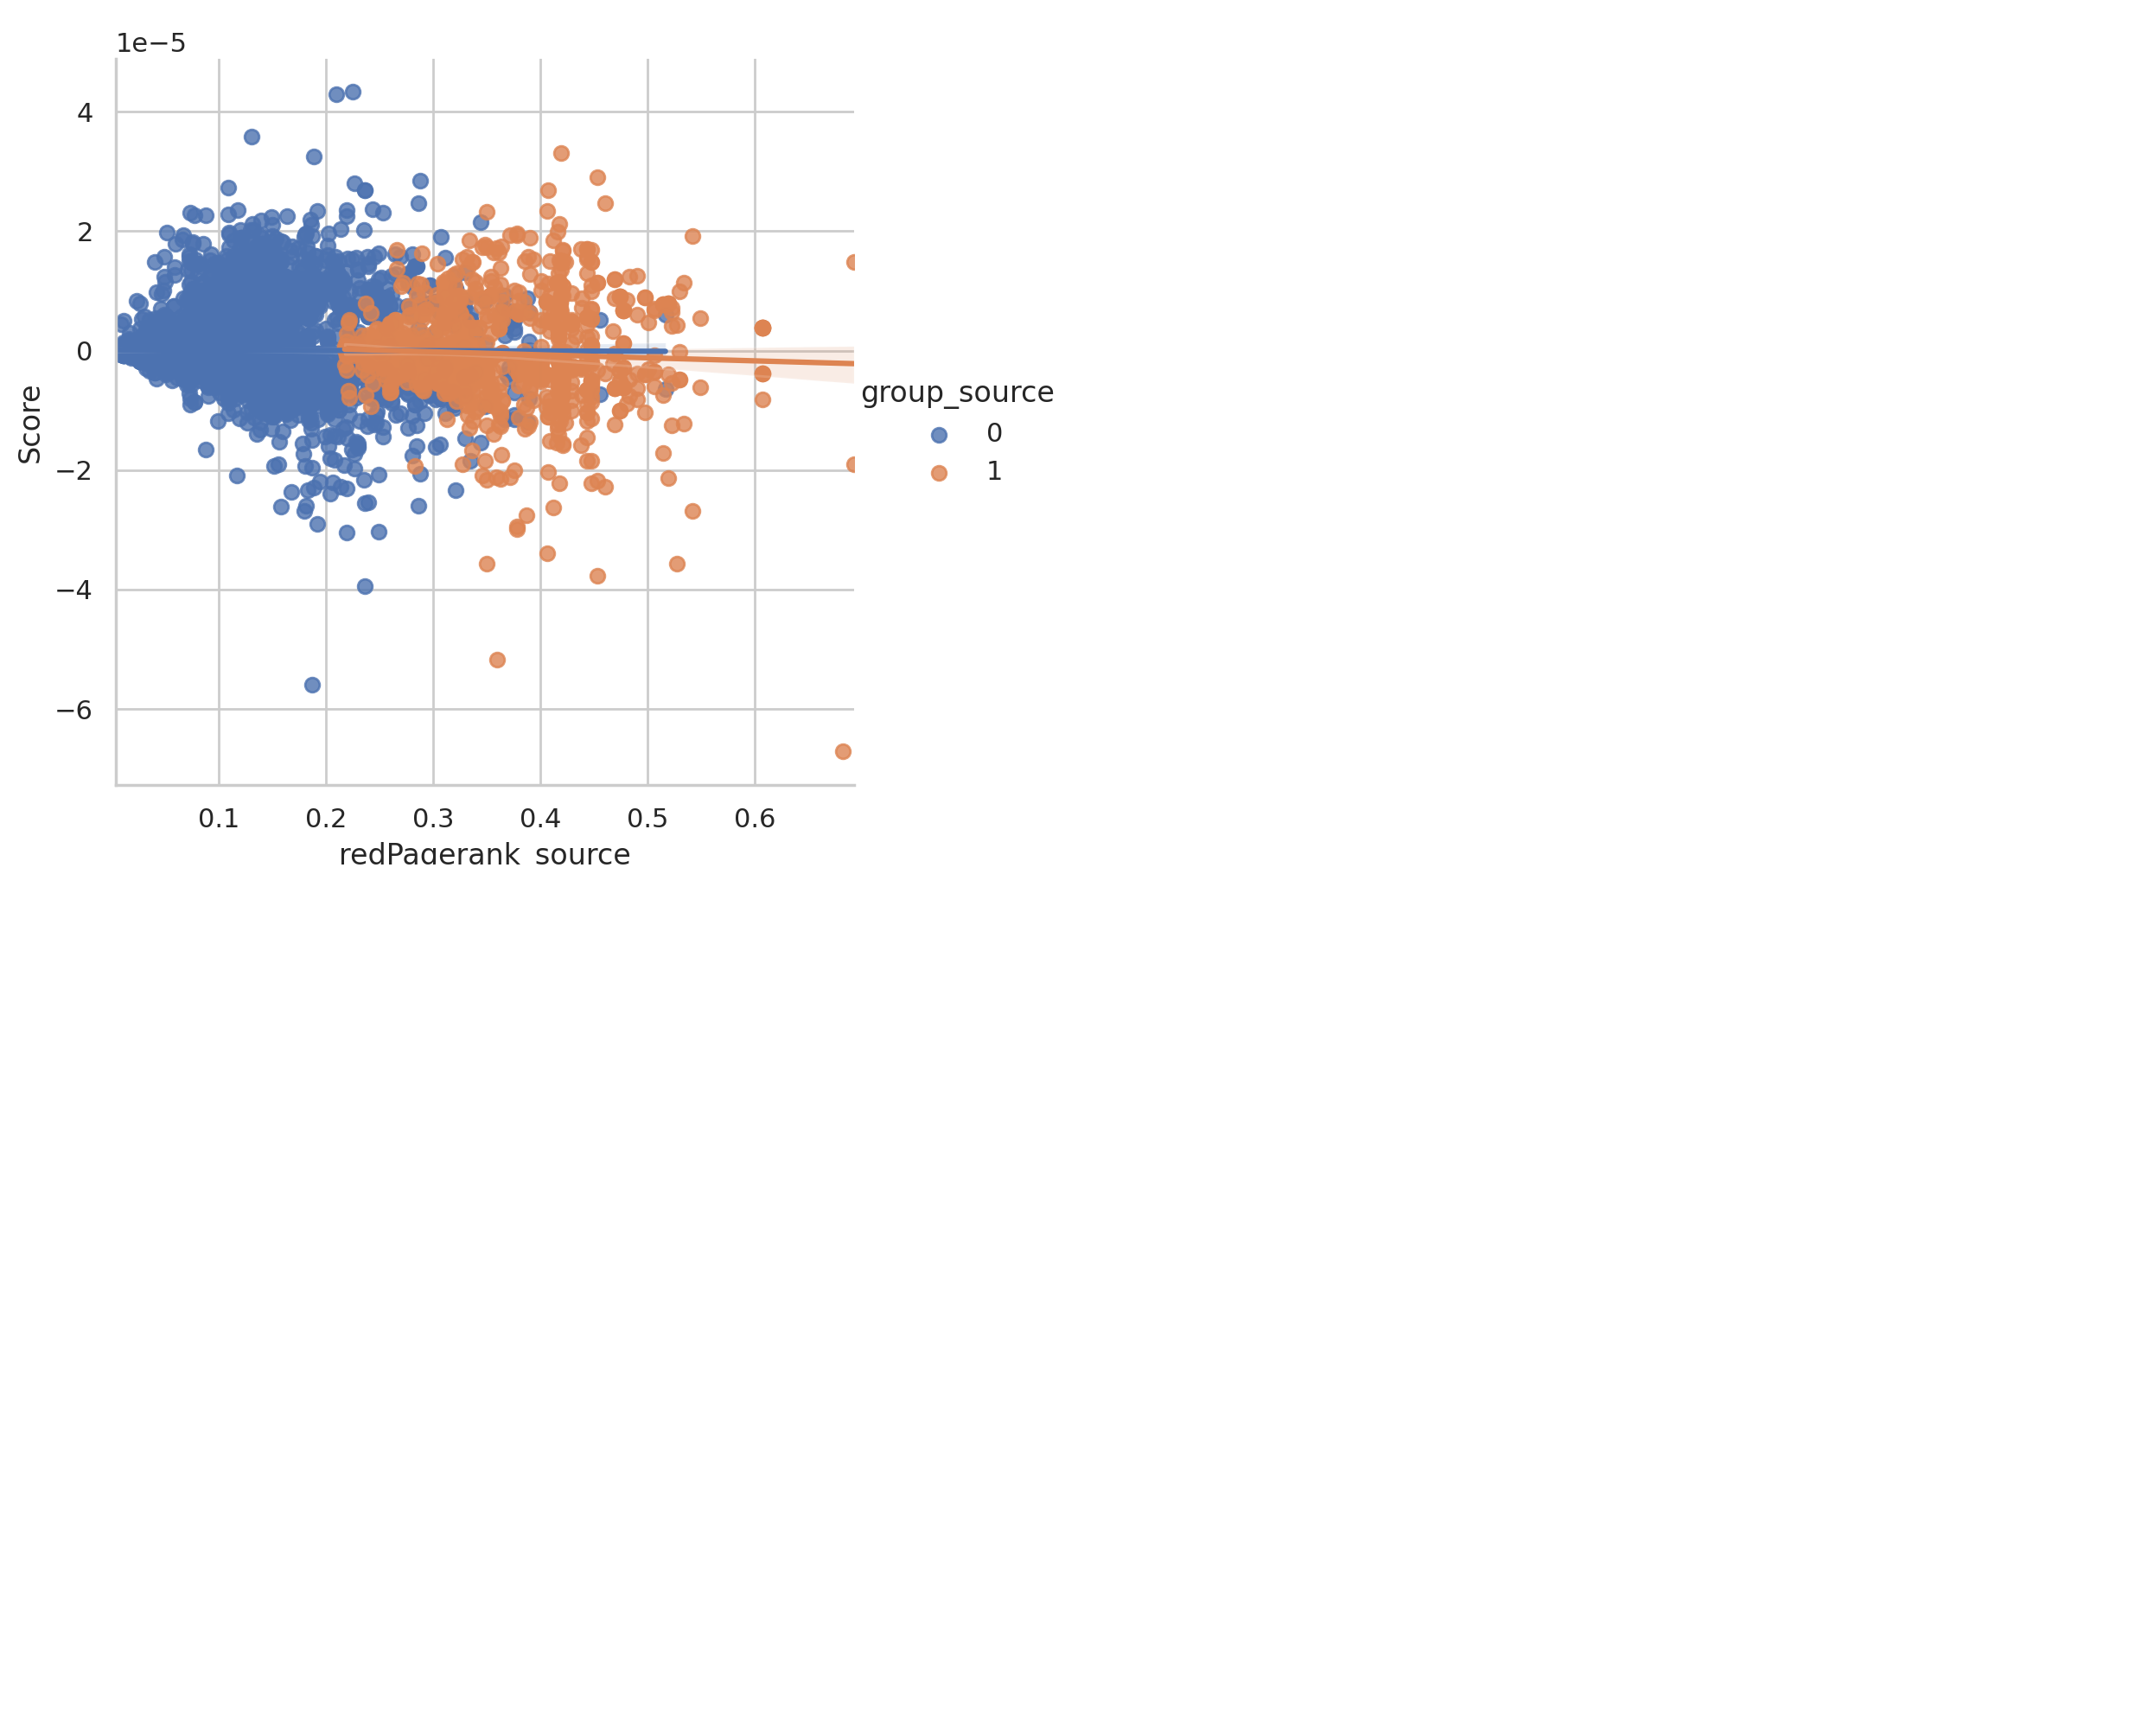

In [104]:
sns.lmplot(x="redPagerank_source",y="Score", hue="group_source", data=dblp)

# Twitter

<IPython.core.display.Javascript object>


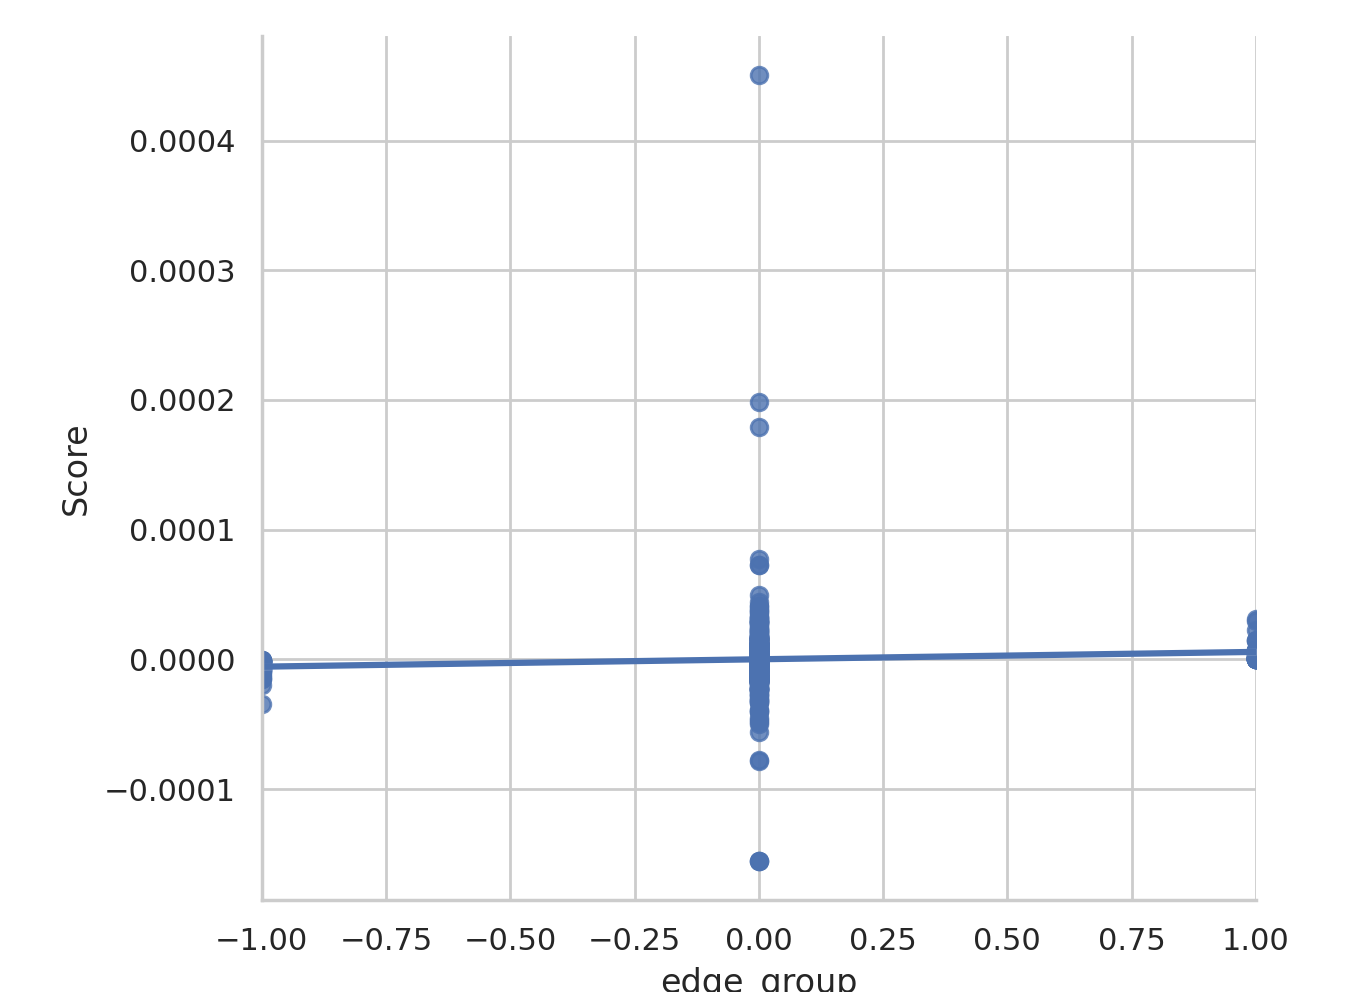

In [115]:
sns.lmplot(x="edge_group",y="Score", data=twitter)

<IPython.core.display.Javascript object>


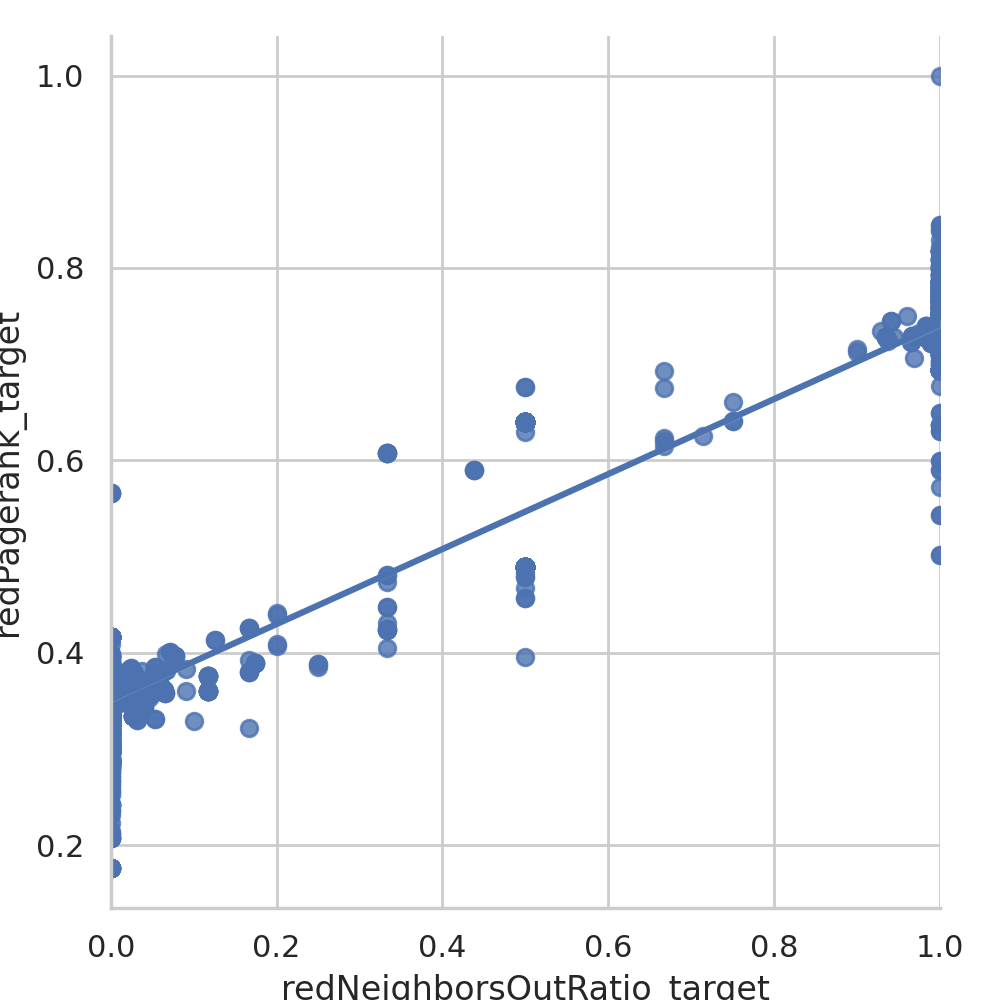

In [98]:
sns.lmplot(x="redNeighborsOutRatio_target",y="redPagerank_target", data=twitter)

<IPython.core.display.Javascript object>


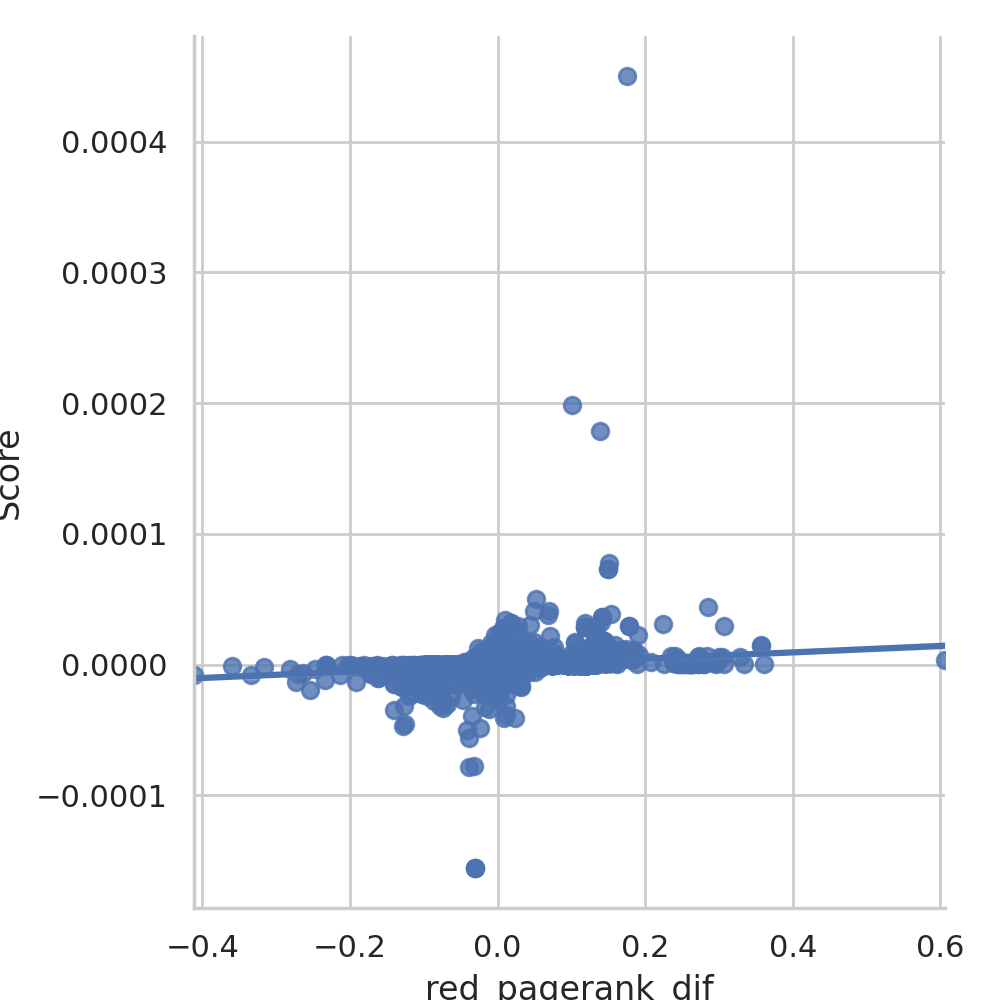

In [99]:
sns.lmplot(x="red_pagerank_dif",y="Score", data=twitter)

<IPython.core.display.Javascript object>


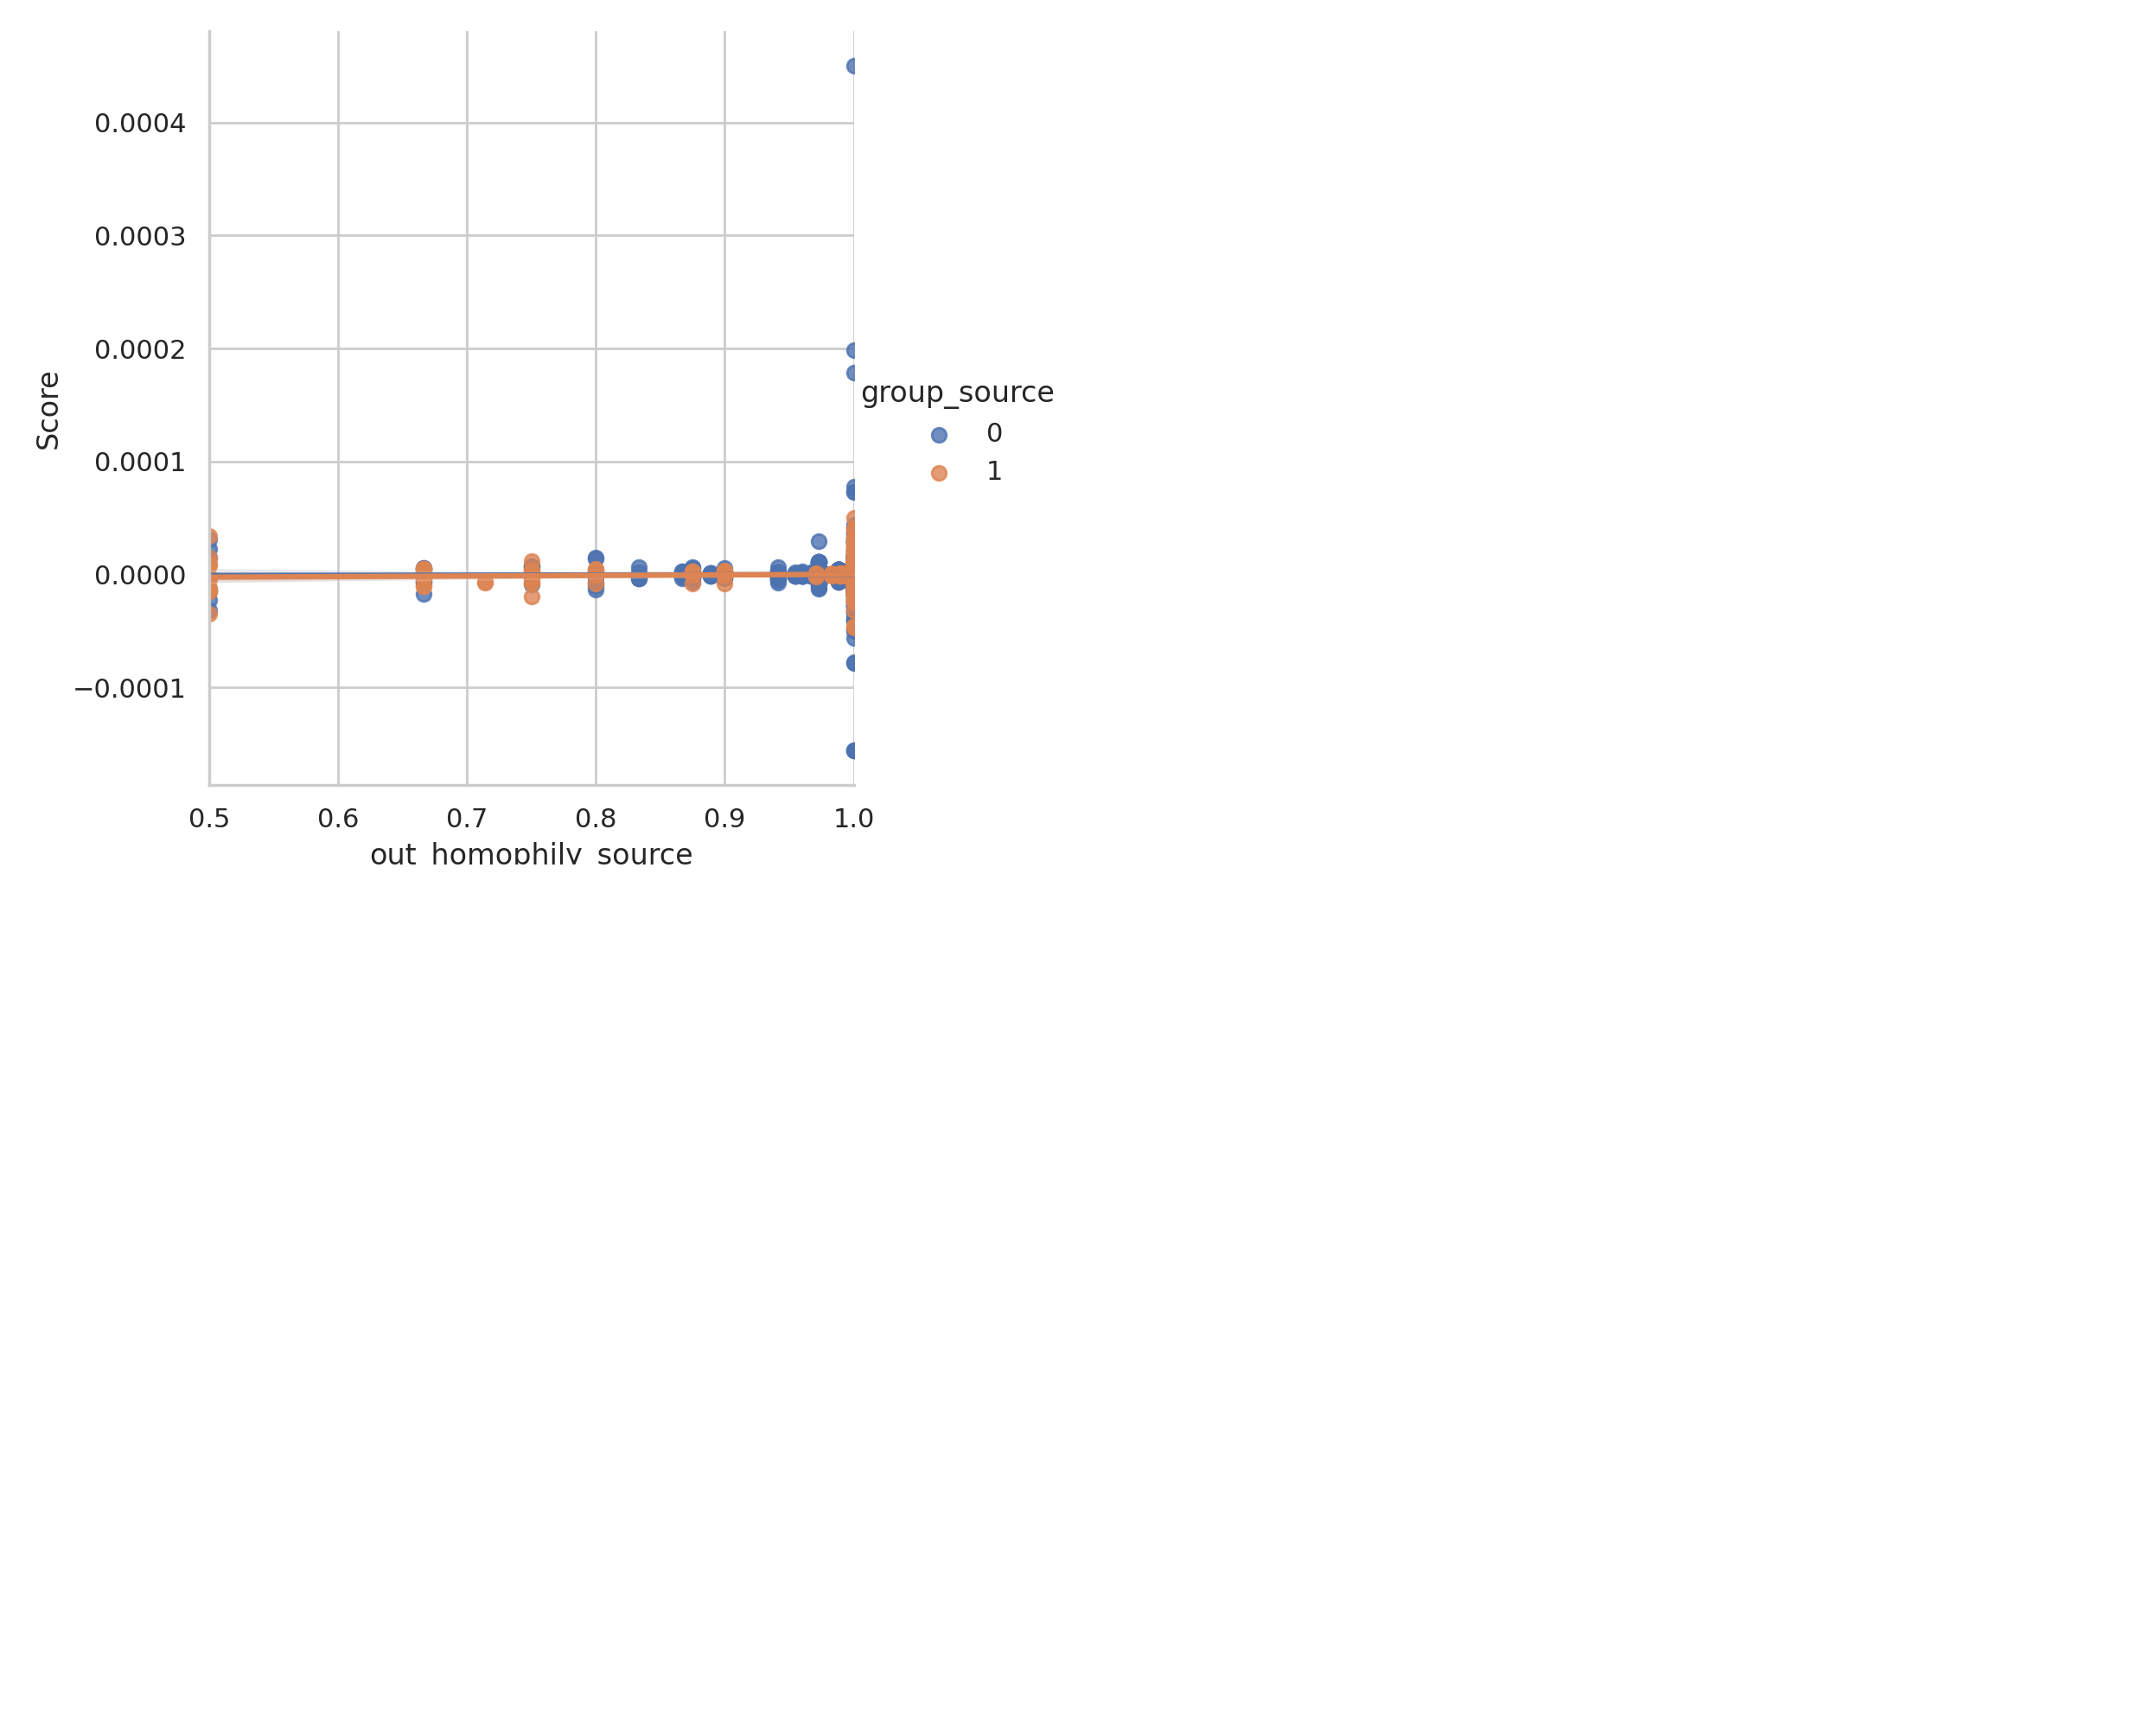

In [102]:
sns.lmplot(x="out_homophily_source",y="Score", hue="group_source", data=twitter)

<IPython.core.display.Javascript object>


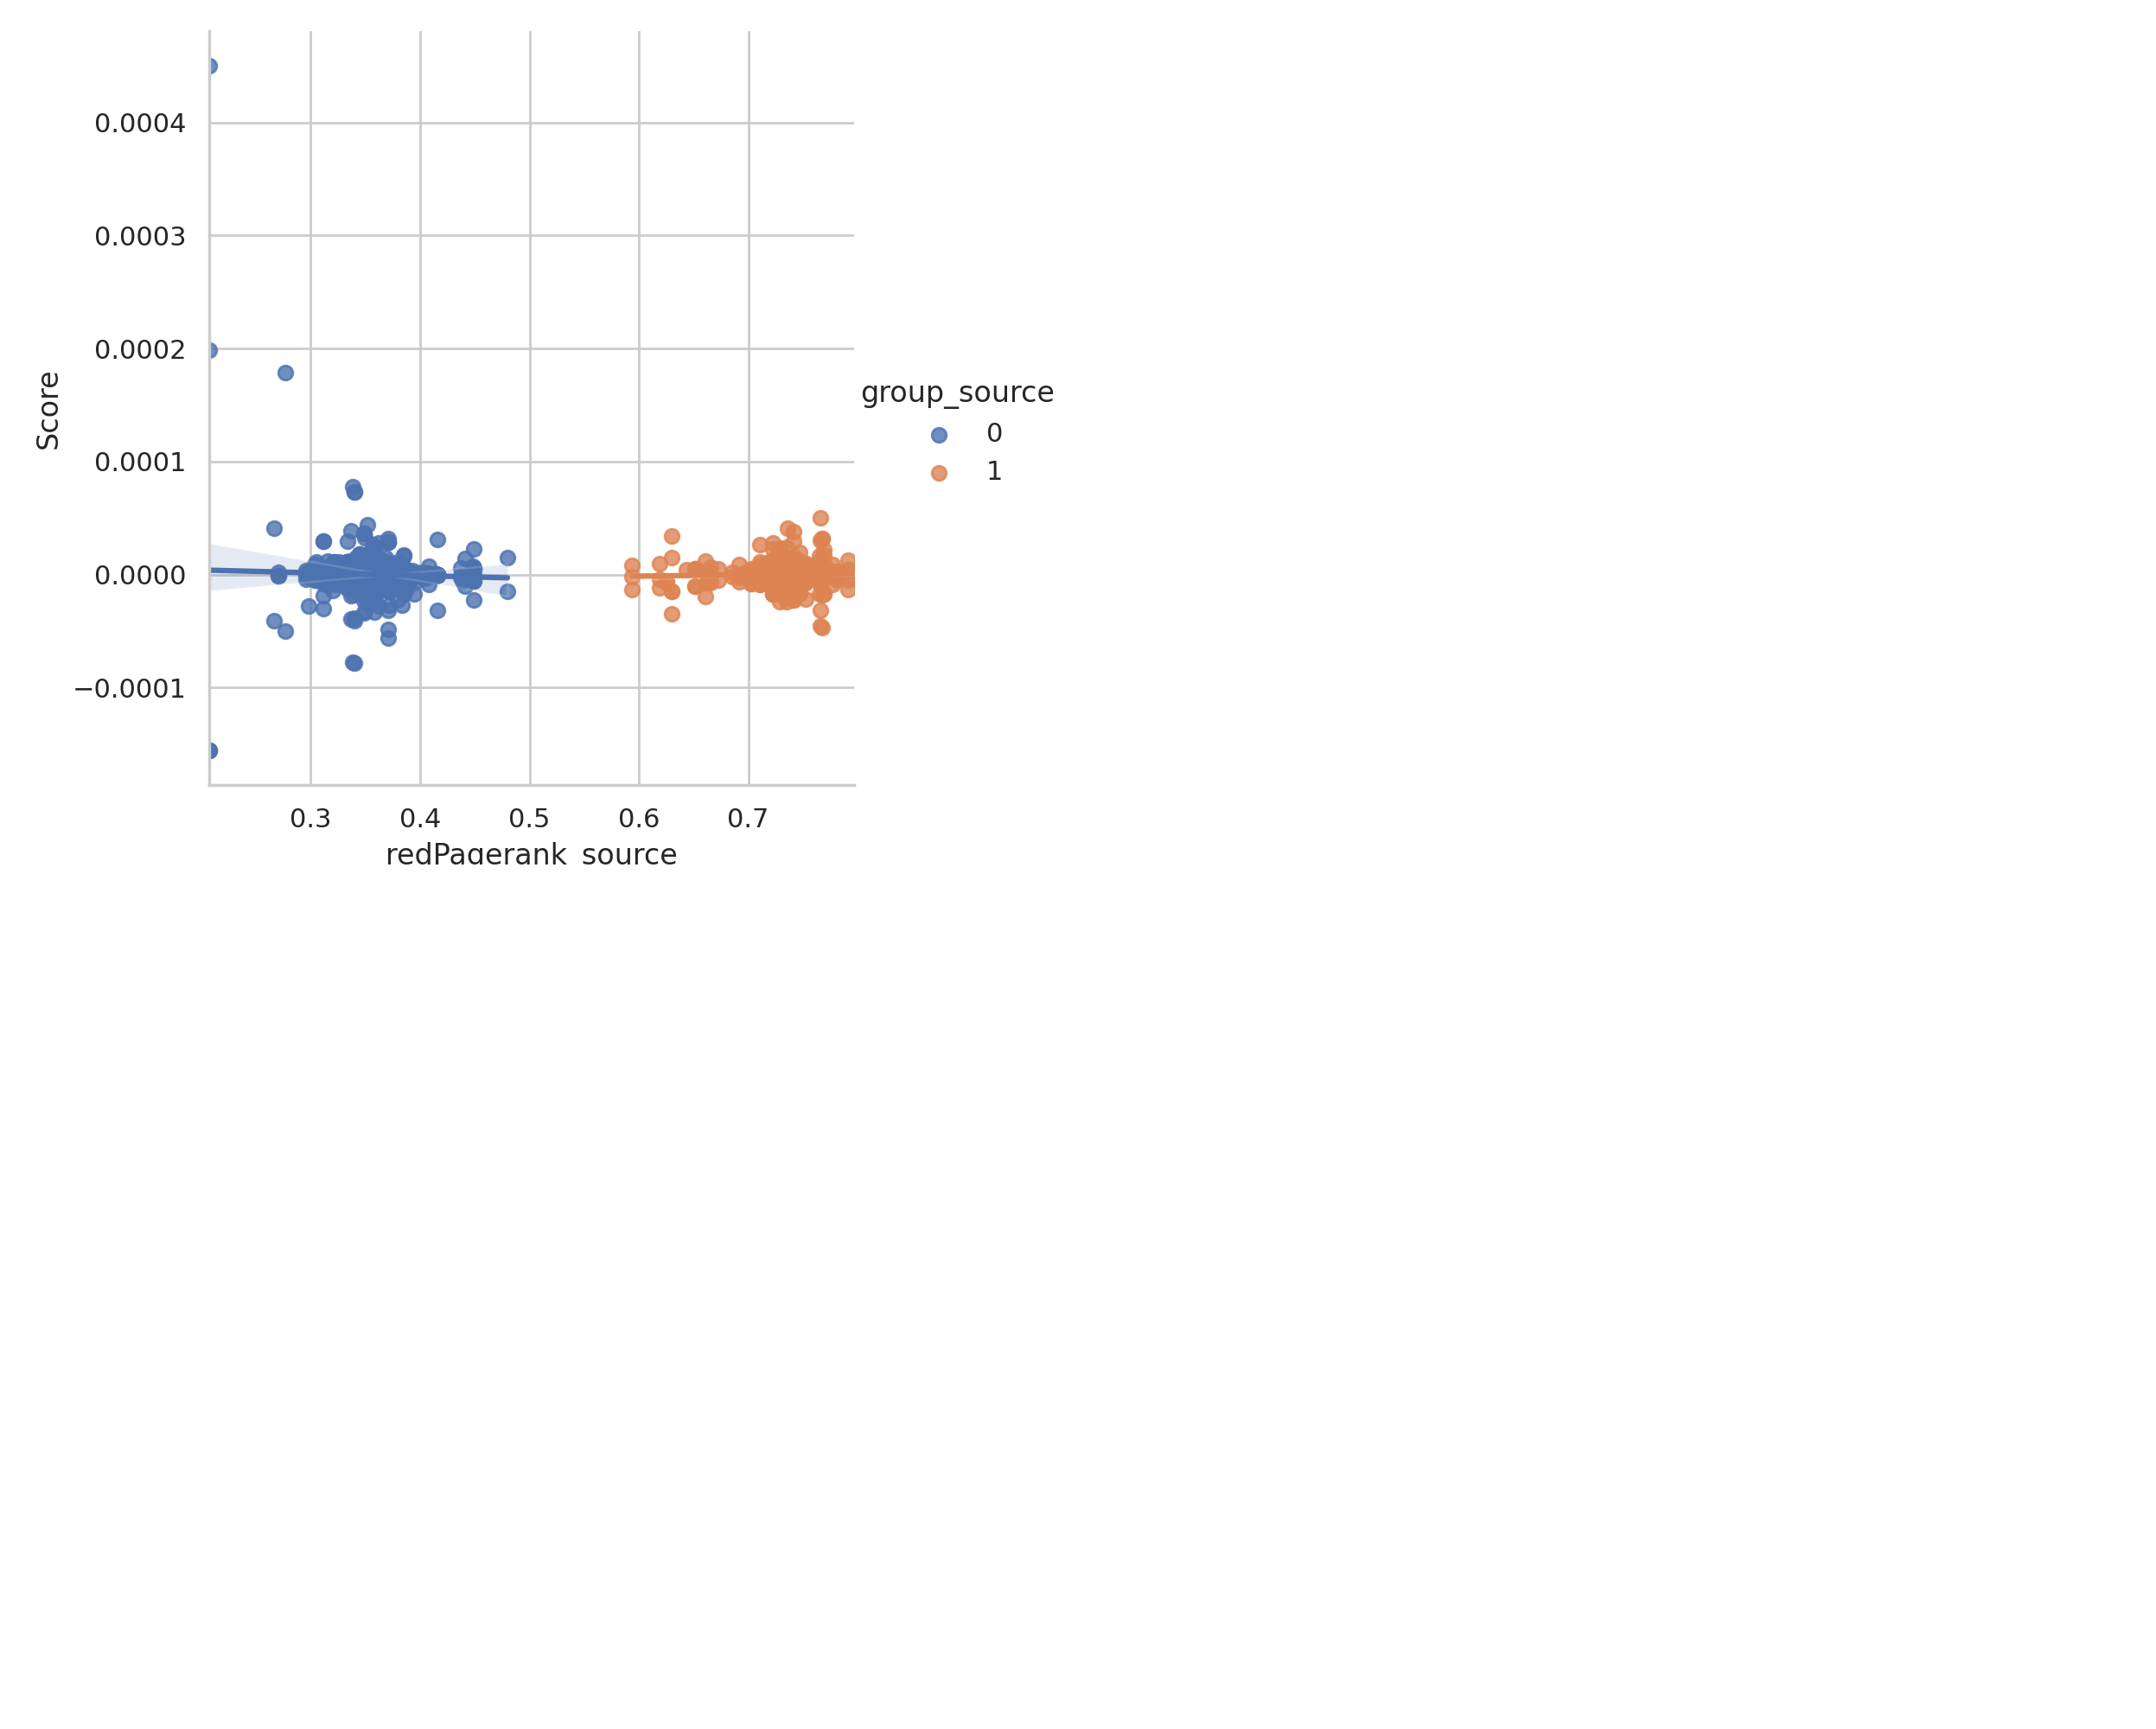

In [103]:
sns.lmplot(x="redPagerank_source",y="Score", hue="group_source", data=twitter)

# Correlation tables

In [212]:
# Pearson.
# Initialization and books.
temp_cor = books.corr(method="pearson").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]
values = list()
for label, value in temp_cor.iteritems():
    values.append(str(label) + " & " + str(round(value, 2)))

# Blogs.
temp_cor = blogs.corr(method="pearson").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]

i = 0
for label, value in temp_cor.iteritems():
    values[i] += " & " + str(round(value, 2))
    i += 1

# Dblp.
temp_cor = dblp.corr(method="pearson").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]

i = 0
for label, value in temp_cor.iteritems():
    values[i] += " & " + str(round(value, 2))
    i += 1

# Twitter.
temp_cor = twitter.corr(method="pearson").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]

i = 0
for label, value in temp_cor.iteritems():
    values[i] += " & " + str(round(value, 2))
    i += 1

# Spearman
# Books.
temp_cor = books.corr(method="spearman").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]

i = 0
for label, value in temp_cor.iteritems():
    values[i] += " & " + str(round(value, 2))
    i += 1
# Blogs.
temp_cor = blogs.corr(method="spearman").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]

i = 0
for label, value in temp_cor.iteritems():
    values[i] += " & " + str(round(value, 2))
    i += 1

# Dblp.
temp_cor = dblp.corr(method="spearman").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]

i = 0
for label, value in temp_cor.iteritems():
    values[i] += " & " + str(round(value, 2))
    i += 1

# Twitter.
temp_cor = twitter.corr(method="spearman").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]

i = 0
for label, value in temp_cor.iteritems():
    values[i] += " & " + str(round(value, 2))
    i += 1

# Print latex table.
print("\\hline")
print("Metric & Books & Blogs & DBLP & Twitter & Books & Blogs & DBLP & Twitter \\\\")
print("\\hline")
for i in values:
    print(i + " \\\\")
    print("\\hline")

\hline
Metric & Books & Blogs & DBLP & Twitter & Books & Blogs & DBLP & Twitter \\
\hline
pagerank_source & -0.0 & -0.0 & 0.0 & 0.03 & 0.12 & -0.12 & -0.04 & -0.0 \\
\hline
redPagerank_source & -0.0 & -0.0 & -0.03 & 0.01 & -0.07 & 0.13 & -0.12 & 0.11 \\
\hline
group_source & -0.0 & -0.0 & -0.03 & 0.01 & 0.17 & 0.11 & -0.02 & 0.06 \\
\hline
inDegree_source & -0.0 & -0.0 & 0.0 & 0.01 & 0.11 & -0.08 & -0.01 & -0.01 \\
\hline
outDegree_source & -0.0 & 0.0 & 0.0 & -0.0 & 0.11 & -0.03 & -0.01 & 0.03 \\
\hline
redNeighborsInRatio_source & -0.0 & 0.0 & -0.03 & 0.0 & -0.08 & 0.14 & -0.17 & 0.06 \\
\hline
redNeighborsOutRatio_source & -0.0 & -0.0 & -0.03 & 0.01 & -0.08 & 0.13 & -0.17 & 0.06 \\
\hline
out_homophily_source & -0.0 & 0.0 & 0.03 & 0.02 & -0.34 & 0.02 & 0.13 & 0.01 \\
\hline
pagerank_target & 0.16 & 0.02 & -0.02 & 0.01 & -0.0 & -0.02 & 0.05 & -0.07 \\
\hline
redPagerank_target & 0.34 & 0.3 & 0.52 & 0.12 & 0.45 & 0.6 & 0.36 & 0.48 \\
\hline
group_target & 0.36 & 0.22 & 0.69 & 0.03 & 0.

In [217]:
books_cor = books.corr(method="pearson").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]
twitter_cor = twitter.corr(method="pearson").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]
blogs_cor = blogs.corr(method="pearson").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]
dblp_cor = dblp.corr(method="pearson").Score[["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"]]


df_ah = pd.DataFrame(columns=["pagerank_source", "redPagerank_source", "group_source", "inDegree_source",
                                               "outDegree_source", "redNeighborsInRatio_source", "redNeighborsOutRatio_source",
                                               "out_homophily_source", "pagerank_target", "redPagerank_target", "group_target",
                                               "inDegree_target", "outDegree_target", "redNeighborsInRatio_target",
                                               "redNeighborsOutRatio_target", "out_homophily_target", "red_pagerank_dif"])
df_ah = df_ah.append(books_cor)
df_ah = df_ah.append(blogs_cor)
df_ah = df_ah.append(dblp_cor)
df_ah = df_ah.append(twitter_cor)
#df_ah["dataset"] = ["Books", "Blogs", "DBLP", "Twitter"]
df_ah

pagerank_source  redPagerank_source  group_source  inDegree_source  \
Score        -0.003073           -0.001767     -0.002593        -0.003128   
Score        -0.000500           -0.000369     -0.000593        -0.000056   
Score         0.003268           -0.034360     -0.030032         0.002688   
Score         0.026637            0.006340      0.009547         0.011610   

       outDegree_source  redNeighborsInRatio_source  \
Score         -0.003128                   -0.001575   
Score          0.000463                    0.001338   
Score          0.002688                   -0.029690   
Score         -0.002710                    0.004776   

       redNeighborsOutRatio_source  out_homophily_source  pagerank_target  \
Score                    -0.001575             -0.004852         0.158349   
Score                    -0.000007              0.001197         0.020311   
Score                    -0.029690              0.025459        -0.018964   
Score                     0.010445              0.016286         0.005089   

       redPagerank_target  group_target  inDegree_target  outDegree_target  \
Score            0.337649      0.363713         0.168272          0.168272   
Score            0.296818      0.215992        -0.056008         -0.096461   
Score            0.520550      0.685986        -0.017825         -0.017825   
Score            0.122238      0.028520         0.002522         -0.006414   

       redNeighborsInRatio_target  redNeighborsOutRatio_target  \
Score                    0.344939                     0.344939   
Score                    0.145877                     0.307598   
Score                    0.134527                     0.134527   
Score                    0.025470                     0.138169   

       out_homophily_target  red_pagerank_dif  
Score              0.096351          0.978057  
Score             -0.008821          0.467185  
Score             -0.597337          0.699229  
Score             -0.040626          0.197231

<IPython.core.display.Javascript object>


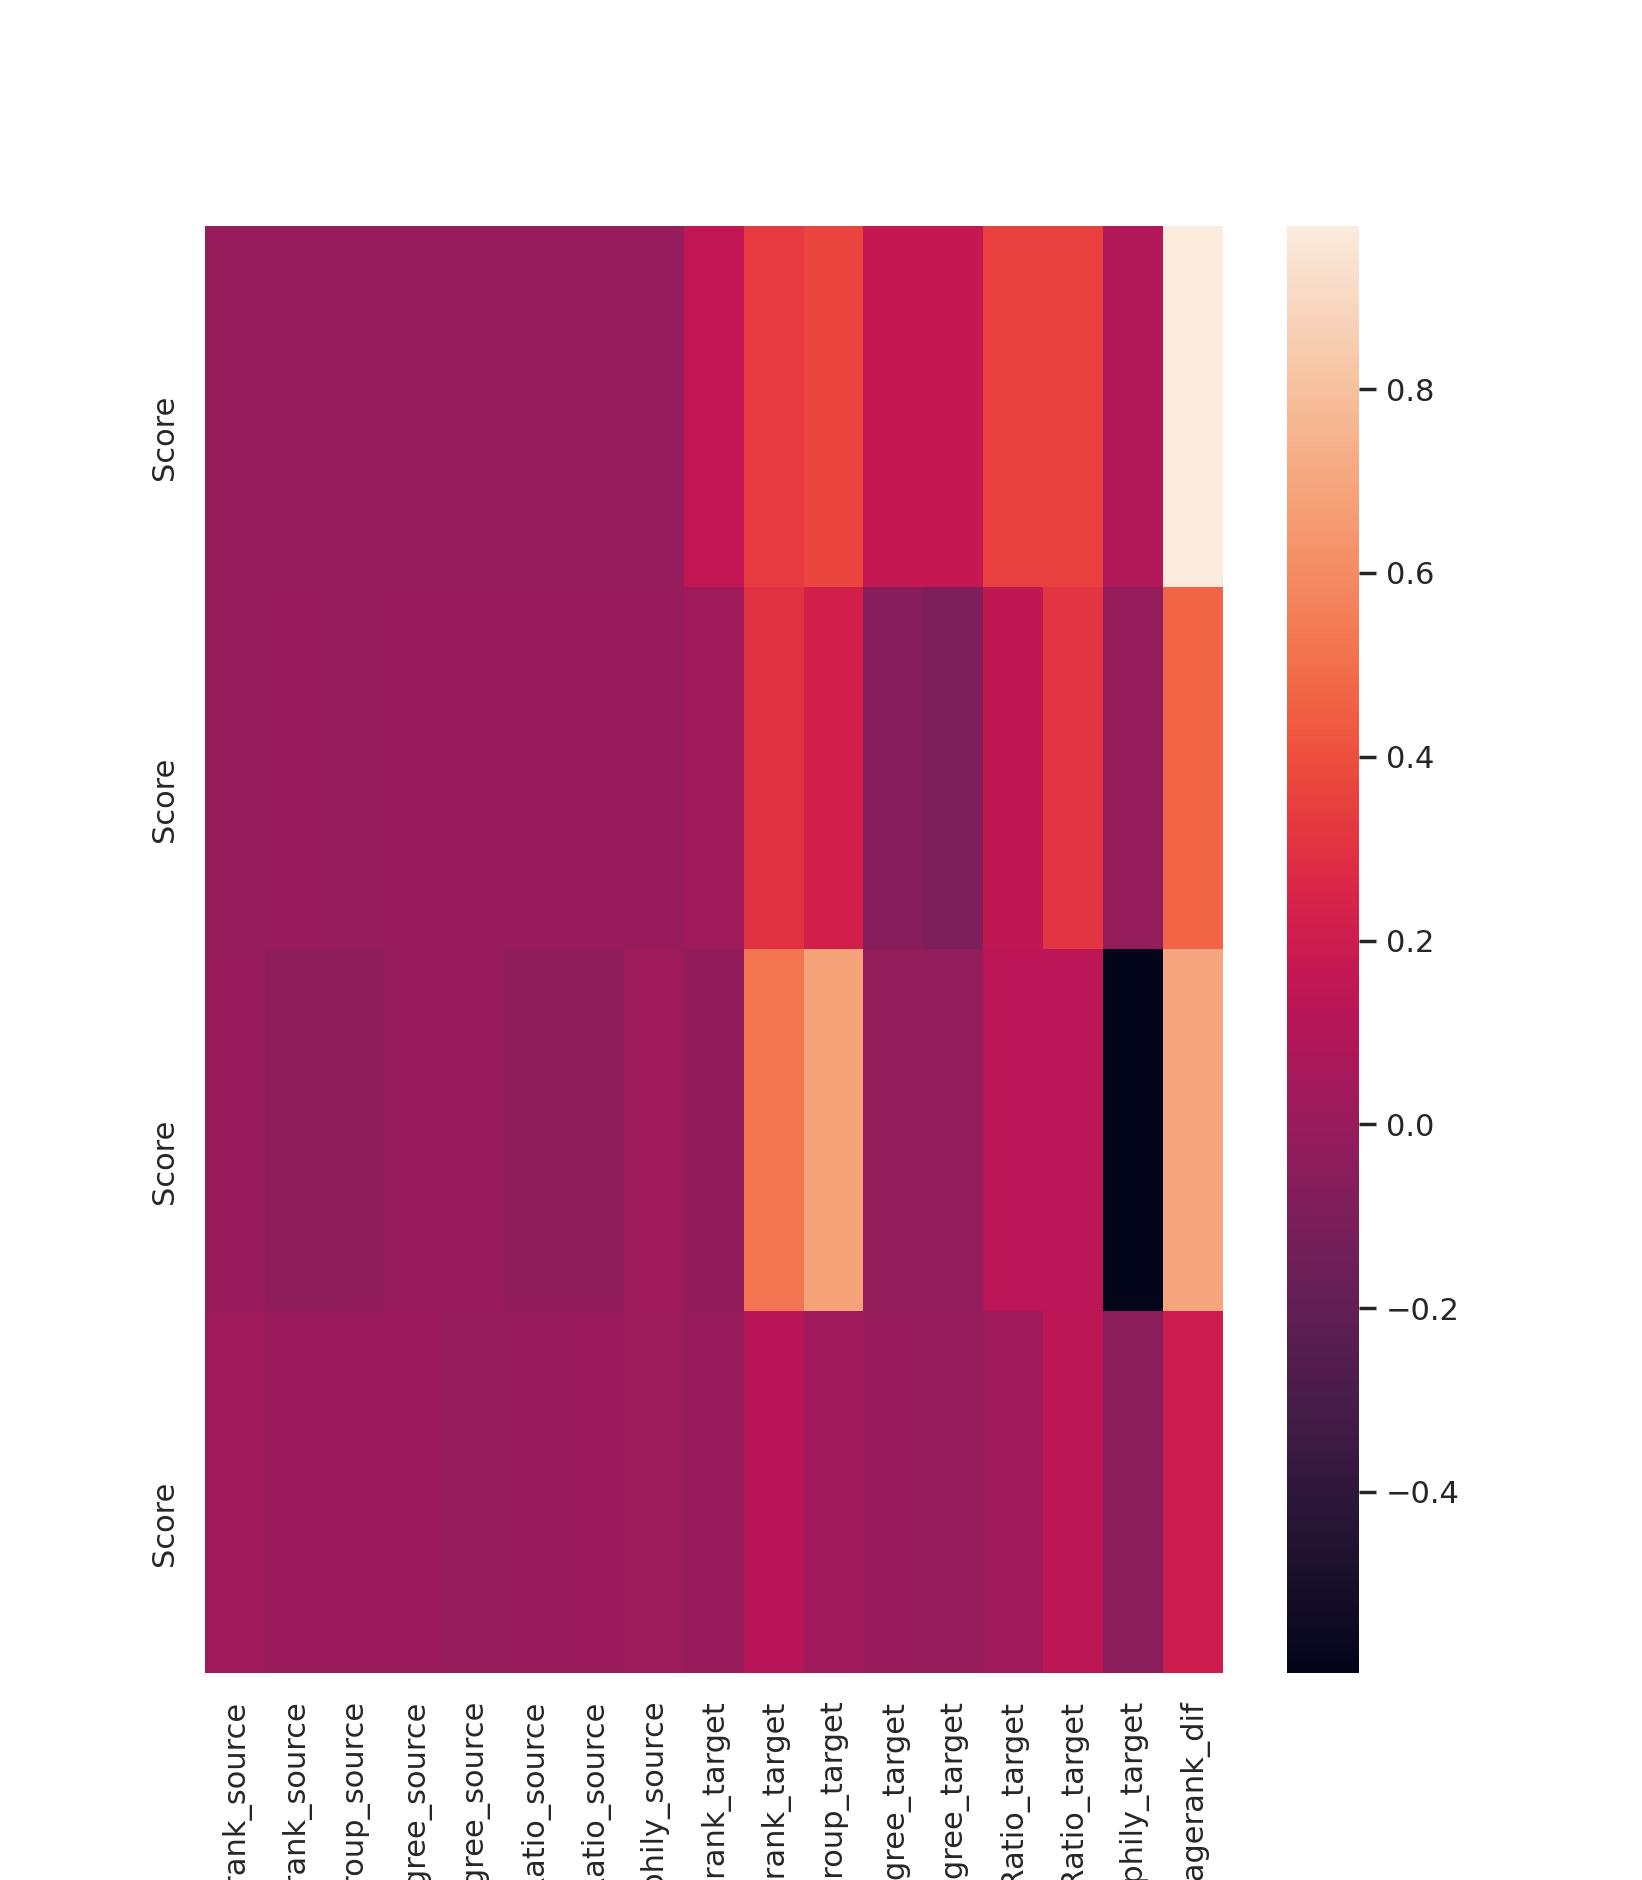

In [218]:
sns.heatmap(df_ah)

# Names

In [193]:
dblp_best = dblp.head(20)[["Source", "Target", "Score"]]
df_best = dblp_best.join(dblp_names.set_index("Node_id"), on="Source", rsuffix="source" )
df_best = df_best.join(dblp_names.set_index("Node_id"), on="Target", lsuffix="_Source", rsuffix="_Target")
dblp_worst = dblp.tail(20)[["Source", "Target", "Score"]]
df_worst = dblp_worst.join(dblp_names.set_index("Node_id"), on="Source", rsuffix="source" )
df_worst = df_worst.join(dblp_names.set_index("Node_id"), on="Target", lsuffix="_Source", rsuffix="_Target")

In [194]:
df_best = df_best[["Author_Name_Source", "Author_Name_Target", "Score"]]
df_worst = df_worst[["Author_Name_Source", "Author_Name_Target", "Score"]].sort_values(axis=0, by="Score")

In [202]:
latex_table = list()
i = 0
for index, row in df_best.iterrows():
    latex_table.append(str(i + 1))
    for label, value in row.iteritems():
        value_t = round(value, 6) if type(value) is float else value
        latex_table[i] += " & " + str(value_t)
    i += 1

i = 0
for index, row in df_worst.iterrows():
    for label, value in row.iteritems():
        value_t = round(value, 6) if type(value) is float else value
        latex_table[i] += " & " + str(value_t)
    i += 1

# Print table in latex code.
print("\\hline")
print("Order & Source & Target & Score & Source & Target & Score")
print("\\hline")
for row in latex_table:
    print(row + "\\\\")
    print("\\hline")

\hline
Order & Source & Target & Score & Source & Target & Score
\hline
1 & Hassan Sayyadi & Lise Getoor & 4.3e-05 & Valeria De Antonellis & Silvana Castano & -6.7e-05\\
\hline
2 & Blake Anderson & Susan T. Dumais & 4.3e-05 & Tevfik Bultan & Richard Hull & -5.6e-05\\
\hline
3 & Michel E. Adiba & Christine Collet & 3.6e-05 & Mizuho Iwaihara & Mukesh K. Mohania & -5.2e-05\\
\hline
4 & Wendy Hall & Leslie Carr & 3.3e-05 & Lionel Martin & Guillaume Cleuziou & -3.9e-05\\
\hline
5 & Ratko Orlandic & Martha W. Evens & 3.2e-05 & Hassina Meziane & Mike P. Papazoglou & -3.8e-05\\
\hline
6 & Hassina Meziane & Salima Benbernou & 2.9e-05 & Jennifer L. Gardy & Martin Ester & -3.6e-05\\
\hline
7 & Michael Klein & Birgitta Konig-Ries & 2.8e-05 & Karen C. Davis & Alfredo Cuzzocrea & -3.6e-05\\
\hline
8 & Mirco Stern & Birgitta Konig-Ries & 2.8e-05 & Marilyn Crilley & David Brill & -3.4e-05\\
\hline
9 & George H. L. Fletcher & Alexandra Poulovassilis & 2.7e-05 & Igor Canadi & Paul Barford & -3e-05\\
\hl

In [201]:
type(0.34) is float

True